# Mixture of Gaussians Example 
We consider the following model for the data as in Minka (2001b) for Expectation Propagation:

$p(\pmb{y}|\pmb{x})=(1-w)\mathcal{N}(\pmb{y};\pmb{x}, \pmb{I})+w\mathcal{N}(\pmb{y};\pmb{0}, a\pmb{I})$

which is a specific example of the general case for the heteroscedastic finite mixture models with only Gaussian distribution:

$p(\pmb{y}|\pmb{\Xi})=\sum_i w_i \mathcal{N}(\pmb{y};\pmb{\mu}_i, \pmb{\Lambda}_i)$, where $\sum_i w_i=1$ and $w_i>0$

Justification for considering Mixture Models:
- They typically arise in practice, for instance, in Medicine
    - Hence an area where local data privacy is considered, and Federated Learning should be applied, since data might be split across clients, e.g. hospitals
- This model is fully misspecified since we fit a single normal to a mixture distribution, i.e. the $\mathcal{M}$-open world

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import math
from __future__ import division
import copy


import torch
import torch.utils.data
import torch.nn as nn
from torch import distributions, nn, optim
from torchvision import transforms, datasets
from scipy.stats import multivariate_normal
import scipy.stats as stats
import numpy as np
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import pandas as pd

#JITTER = 1e-2

%matplotlib inline
torch.set_default_dtype(torch.float64)

In [2]:
torch.manual_seed(86_960_947)

## Helper Functions

In [3]:
def homogeneous_split(data, partitions):
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    
    client_data = []
    for i in range(partitions):
        client_idx = perm[i::partitions]
        client_data.append(data[client_idx])
    
    return client_data

def get_batch(data, length):
    assert length > 0, "Can't use batch of size 0"
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    idx_0 = perm[0]
    batch = torch.atleast_2d(data[idx_0])
    l = min(len(data), length)
    
    for i in range(1, l):
        client_idx = perm[i]
        samp = torch.atleast_2d(data[client_idx])
        batch = torch.cat((batch, samp), 0)
    return batch

# Will generate random sized partitions of the data, dependent on the size of the previous partitions
def heterogeneous_split(data, partitions):
    
    l = len(data)
    weights = []
    for i in range(partitions-1):
        w_i = torch.distributions.uniform.Uniform(torch.tensor([1.]), (l-partitions+i)).sample()
        w = torch.floor(w_i)
        weights.append(w.numpy())
        l -= w
    weights.append(l.numpy())
    
    client_data = []
    counter = 0
    for w in weights:
        client_x_n = data[counter:int(counter+w[0])]
        client_data.append(client_x_n)
        counter += w[0]
        counter = int(counter)
        
    return client_data
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure(figsize=(6,4))
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()

In [4]:
# Miscellaneous colour map definitions for visualising different contour plots at the same time

cmap1 = ['lightsalmon', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato']
cmap2 = ['teal', 'forestgreen', 'limegreen', 'mediumspringgreen', 'aquamarine', 'mediumturquoise']
cmap3 = ['palevioletred', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato', 'lightsalmon']


## Definition of function of mixture of two 2D normals
We assume that the covariance matrix is some coefficient times the identity matrix:

$\mathcal{N}(\pmb{y};\pmb{x}, c\pmb{I})=\frac{1}{2\pi |c\pmb{I}|^{1/2}}\exp \{-\frac{1}{2}(\pmb{y}-\pmb{x})^T(c\pmb{I})^{-1}(\pmb{y}-\pmb{x})\}=\frac{1}{2c\pi} \exp \{-\frac{1}{2c}(\pmb{y}-\pmb{x})^T(\pmb{y}-\pmb{x})\}, \; c\in \mathbb{R}, \pmb{x},\pmb{y}\in \mathbb{R}^2, \pmb{I}\in\mathbb{R}^{2\times2}$

$=\frac{1}{2c\pi}\exp \{-\frac{1}{2c}((y_1-x_1)^2+(y_2-x_2)^2)\}$

In [5]:
def Normal(mean, cov_coef, x, D):
    assert D > 0, "negative dimensional data"
    if D > 2:
        s = np.dot((x-mean),(x-mean))
    elif D == 2:
        if torch.is_tensor(x):
            x = x.squeeze(0).numpy()
        s = (x[0] - mean[0]) ** 2 + (x[1] - mean[1]) ** 2
    else:
        s = (x-mean) ** 2
    return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))

In [6]:
class Gaussian:
    #Change to log sum exp instead of explicitly evaluating this
    
    def Gaussian(mean, cov, theta):
        assert cov.shape[0] > 0, "Dimensionality specified incorrectly"
        if cov.shape[0] == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            assert mean.shape[0] == cov.shape[1], "Not the same dimension, multiplication not possible"

            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), torch.linalg.solve(cov, vector.unsqueeze(-1)))

            det = torch.linalg.det(cov) ** 0.5

            coef_ = det * ((np.pi * 2) ** (cov.shape[0] / 2))
            
            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
        
    def SphericalGaussian(mean, cov, theta, D):
        assert D > 0, "Negative dimension in spherical Gaussian"
        if D == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), vector.unsqueeze(-1)) / cov

            coef_ = torch.pow(torch.abs(cov * np.pi * 2), (D / 2))

            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
    
    def Normal(mean, cov, theta, D):
        if D is None:      
            return Gaussian.Gaussian(mean, cov, theta)
        else:
            return Gaussian.SphericalGaussian(mean, cov, theta, D)
    
    def GaussianMixture(mean_list, cov_list, theta, parameters, D=None):
        ret = 0.
        assert len(mean_list) == len(parameters), "Different list lengths"
        assert len(mean_list) == len(cov_list), "Different list lengths"
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
                
        if D is None:      
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.Gaussian(mean_list[i], cov_list[i], theta)
        else:
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.SphericalGaussian(mean_list[i], cov_list[i], theta, D)
            
        return ret
    
    def SampleFromMixture(mean_list, cov_list, parameters, num_samples, include_mean=False):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, parameters).sample()
        component_sample_num = sample_nums.numpy()
        samples = torch.tensor([])
        mean = torch.zeros_like(mean_list[0])
        
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            if include_mean:
                mean = m_i.mean(dim=0)
                
            sample = m_i.sample((int(component_sample_num[i]),))
            samples = torch.cat((samples, sample), 0)
        if include_mean:     
            return samples, mean
        else:
            return samples
    
    def HeterogenousSampleMix(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        
        client_data =[]
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            client_data.append(sample)
                
        return client_data
        

### Applying the mixture of Normals

In [7]:
def Mixture(x, w, mean_1, cov_coef_1, mean_2, cov_coef_2, D):
    return (1 - w) * Normal(mean_1, cov_coef_1, x, D) + w * Normal(mean_2, cov_coef_2, x, D)

### One Dimensional Case of probability distributions

In [8]:
def Normal1d(mean, var, x):
    return np.exp(-((x-mean) ** 2)/(2 * var))/ ((np.absolute(2 * var * np.pi)) ** 0.5)

def Mix(x, w, m_1, var_1, m_2, var_2):
    return (1-w)* Normal1d(m_1, var_1, x) + w * Normal1d(m_2, var_2, x)

## Partitioned Variational Inference for the Mixtures of Gaussians

We initialize the approximating distributions as in the EP algorithm, we repeat this here for clarity:
The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
\pi(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{k=1}^Np(\pmb{x}_k|\pmb{\theta})$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [M],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\pi(\pmb{\theta})\prod_{n=1}^Mt_n(\pmb{\theta})$

The PVI algorithm, stated in Algorithm ... in my paper reduces to the following:
### PVI Algorithm Initialization:
We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,M$

We initialize this through setting $s_n=1$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

For each iteration $i$ until convergence do:

For each client $n\in{1,...,M}$, do:

### Step 1

$q^{new}(\pmb{\theta})=\mathrm{arg\, max}_{q\in\mathcal{Q}}\int \log \frac{q^{(i-1)}(\pmb{\theta})p(\pmb{y}_n|\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})q(\pmb{\theta})}dq(\pmb{\theta}) = 
\mathrm{arg\, min}_{q\in\mathcal{Q}}\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\frac{1}{Z_n}\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})\bigr), Z_n=\int\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})d\pmb{\theta}$

$=\mathrm{arg\,max}_{q\in\mathcal{Q}} \Big\{ \sum_{k\neq \{0,n\}}^N\mathbb{E}_{q(\pmb{\theta})}\big[\log t_k^{(i-1)}(\pmb{\theta})\big]+\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_k}|\pmb{\theta}) \big]  - \mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\pi(\pmb{\theta})\bigr)\Big\}
$

$ =\mathrm{arg\,min}_{q\in\mathcal{Q}} \Big\{\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|q^{\backslash n}(\pmb{\theta})\bigr) -\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_j}|\pmb{\theta}) \big] \Big\}
$
### Step 2

Update $t_n(\pmb{\theta})$:

$t^{(i)}_n(\pmb{\theta})\propto \frac{q^{new}(\pmb{\theta})}{q^{(i-1)}(\pmb{\theta})}t^{(i-1)}_n(\pmb{\theta})$

and pass $\Delta_n(\pmb{\theta}) = \frac{t^{(i)}_n(\pmb{\theta})}{t^{(i-1)}_n(\pmb{\theta})}$ to the server.

### Step 3

At the server, update the global approximate likelihood $q^{(i)}(\pmb{\theta})$:

$q^{(i)}(\pmb{\theta})=q^{(i-1)}(\pmb{\theta})\Delta_n(\pmb{\theta})$

#### KLD between two Multivariate Gaussians
The KLD between two $d$-dimensional Multivariate Gaussians $q(\theta)\sim \mathcal{N}(\mu,\Sigma)$ and $p(\theta)\sim\mathcal{N}(\eta,\Lambda)$ is defined as follows:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl((\eta-\mu)^\top\Lambda^{-1}(\eta-\mu)+\mathrm{tr}(\Lambda^{-1}\Sigma)+\log \frac{|\Lambda|}{|\Sigma|}-d\bigr)
$

Which, in the case of spherical Gaussians, i.e. $q(\theta)\sim \mathcal{N}(\mu,\alpha\mathrm{I}_d)$ and $p(\theta)\sim\mathcal{N}(\eta,\beta\mathrm{I}_d)$, redused to the following:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl(\frac{1}{\beta}(\eta-\mu)^\top(\eta-\mu) +d\frac{\alpha}{\beta}-d\log\frac{\alpha}{\beta} -d\bigr)
$

#### The Alpha Renyi Divergence between two spherical Gaussians is

$\mathrm{D}_{AR}^{(\alpha)}(q(\theta)||\pi(\theta))= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}\log\frac{\alpha \lambda +(1-\alpha)\sigma}{\sigma^{1-\alpha}\:\lambda^{\alpha}}$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}(\log (\alpha \lambda +(1-\alpha)\sigma) - \log (\sigma^{1-\alpha}\:\lambda^{\alpha}))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} + \frac{D}{2\alpha(\alpha-1)}(\log (\sigma^{1-\alpha}\:\lambda^{\alpha})-\log (\alpha \lambda +(1-\alpha)\sigma))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha}\log (\sigma) + \frac{D}{2(\alpha-1)}\log(\lambda)-\frac{D}{2\alpha(\alpha-1)}\log (\alpha \lambda +(1-\alpha)\sigma))$

In [31]:
def Divergence(q_original, p_likelihood, client, parameters):
    
    div = parameters["Divergence"]
    
    q_approximation = copy.deepcopy(q_original)
    
    if div == "KLD":
        print("Not implemented")
    elif div == "Alpha":
        print("Not implemented")
    elif div == "AR":
        print("Not implemented")
    
    return None  

def kl_gaussians(loc_1, loc_2, cov_1, cov_2):
        # Compute KL(p||q)= E_p(x)[log p(x) - log q(x)]
    assert loc_1.shape == loc_2.shape, "Not same dimension of means"
    assert cov_1.shape == cov_2.shape, "Not same Cov Matrix dimension"
    assert cov_1.shape[0] == cov_1.shape[1], "Not square matrix"

    d = cov_1.shape[0]
    diff = loc_2 - loc_1
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(cov_2, diff.unsqueeze(-1))).squeeze()
    part_2 = torch.trace(torch.linalg.solve(cov_2, cov_1)).squeeze()
    part_3 = (torch.log(torch.linalg.det(cov_2)) - torch.log(torch.linalg.det(cov_1))).squeeze()

    #print(part_1, part_2, part_3, d)

    return (part_1 + part_2 + part_3 - d) / 2
    
def kl_spherical_gaussian(loc_1, loc_2, cov_1, cov_2, config):    
    
    diff = loc_2 - loc_1
    
    part_1 = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze() / cov_2
    
    part_2 = config["D"] * cov_1 / cov_2
    
    part_3 = config["D"] * torch.log(torch.abs(cov_1) / torch.abs(cov_2))
    
    return (part_1 + part_2 - part_3 - config["D"]) / 2
    
def alpha_renyi(loc_1, loc_2, cov_1, cov_2, config):
    
    alpha = config["alpha"]
    
    diff = loc_2 - loc_1
    
    lin = (alpha * cov_2) + ((1 - alpha) * cov_1)
    
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(lin, diff.unsqueeze(-1))).squeeze()
    
    part_2 = torch.log(torch.linalg.det(lin)).squeeze() / (alpha * (alpha - 1))
    
    part_3 = torch.log(torch.linalg.det(cov_1)).squeeze() / alpha
    
    part_4 = torch.log(torch.linalg.det(cov_2)).squeeze() / (1 - alpha)
    
    return (part_1 - part_2 - part_3 - part_4) / 2
    
def alpha_renyi_spherical(loc_1, loc_2, var_1, var_2, config):
    
    diff = loc_1 - loc_2
    
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    
    lin = (config["alpha"] * var_2 + (1 - config["alpha"]) * var_1)
    
    part_1 = part_1_ / (2 * lin)
    
    coef_1 = config["D"] / (2 * config["alpha"])
    
    coef_2 = config["D"] / (2 * (config["alpha"] - 1))
    
    coef_3 = config["D"] / (2 * config["alpha"] * (config["alpha"] - 1))
    
    part_2 = coef_1 * torch.log(var_1)
    
    part_3 = coef_2 * torch.log(var_2)
    
    part_4 = coef_3 * torch.log(lin)
    
    return part_1 - part_2 + part_3 - part_4

def gamma_spherical(loc_1, loc_2, var_1, var_2, config):
    
    var_1 = torch.abs(var_1)
    var_2 = torch.abs(var_2)
    
    D = config["D"]
    gamma = config["gamma"]
    
    diff = loc_1 - loc_2
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    lin = (var_2 + (gamma - 1) * var_1)
    part_1 = (part_1_ / (2 * lin)).squeeze()
    
    part_2 = (D / (2*gamma - 2)) * torch.log(lin).squeeze()
    
    part_3 = (D / (gamma -1)) * torch.log(var_1).squeeze()
    
    #Only parts 1-3 are relevant for optimisation but taking out the constants might make convergence metrics
    #have different numbers that the ELBO converges to
    
    part_4 = (gamma/(gamma-1))*torch.log(torch.tensor(2*np.pi))
    
    part_5 = ((D*gamma)/(2*gamma - 2))*torch.log(var_2).squeeze()
    
    part_6 = (D/2)*torch.log(torch.tensor(2*np.pi)).squeeze()
    
    part_7 = (D/(2*gamma - 2))*torch.log(torch.tensor(gamma)).squeeze()
    
    const = part_6 - part_7 - part_5 - part_4
    #const = 0.
    
    return part_1 + part_2 + part_3 + const
    
def FisherRao_normals(mu_1, sigma_1_sq, mu_2, sigma_2_sq):
    sigma_1 = sigma_1_sq ** 0.5
    sigma_2 = sigma_2_sq ** 0.5
    
    diff_mu = (mu_2-mu_1) ** 2
    neg_sigma = (sigma_2-sigma_1) ** 2
    pos_sigma = (sigma_2+sigma_1) ** 2
    numerator = diff_mu + 2*neg_sigma
    denominator = diff_mu + 2*pos_sigma
    Delta = (numerator / denominator) ** 0.5
    
    frac = (1 + Delta) / (1-Delta)
    
    FR = (2 ** 0.5) * (frac.log())
    
    return FR

In [32]:
def PartitionedVariationalInference(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        for n in range(len(clients)):
            q_global, t_new = Client.update_q(clients[n], q_global, parameters, config)
            
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            

        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
            
    return q_global, clients
    

In [33]:
def SynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
    
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        elbo_i = 0.
        
        q_global_list = []
        for n in range(len(clients)):
            temp = copy.deepcopy(q_global)
            q_global_list.append(temp)
            
        for n in range(len(clients)):
            print(f"Client {n}")
            q_new_n, t_new = Client.update_q(clients[n], q_global_list[n], parameters, config)
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            
            #Can we simply pass the q_global_list? instead of doing this to the clients?
            #clients[n]["q_n"]["loc"] = q_new_n["loc"].detach()
            #clients[n]["q_n"]["var"] = q_new_n["var"].detach()
            
            elbo_i += q_new_n["metrics"]["elbos"][i]
        
        q_global = aggregate_posteriors(q_global, q_global_list, elbo_i)
        
        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break
            
    return q_global, clients

def aggregate_posteriors(q_global, q_global_list, elbo):    
    M = len(q_global_list)
    
    denom_var_inv = (M-1) * torch.linalg.inv(q_global["var"].detach())
    denom_var = torch.linalg.inv(denom_var_inv)
    
    denom_mean = torch.matmul(denom_var, (M-1) * torch.linalg.solve(
        q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1)))
    
    numer_var_inv = torch.zeros_like(q_global["var"].detach())
    for q in q_global_list:
        numer_var_inv += torch.linalg.inv(q["var"].detach())
        
    numer_var = torch.linalg.inv(numer_var_inv)
    
    numer_var_mean = torch.linalg.solve(
        q_global_list[0]["var"].detach(), q_global_list[0]["loc"].detach().unsqueeze(-1))
    
    for i in range(1, len(q_global_list)):
        numer_var_mean += torch.linalg.solve(
            q_global_list[i]["var"].detach(), q_global_list[i]["loc"].detach().unsqueeze(-1))
        
    numer_mean = torch.matmul(numer_var, numer_var_mean)
    
    q_new_var_inv = numer_var_inv - denom_var_inv
    
    q_new_var = torch.linalg.inv(q_new_var_inv)
    
    q_new_var_mean = torch.matmul(numer_var_inv, numer_mean) - torch.matmul(denom_var_inv, denom_mean)
    
    q_new_mean = torch.matmul(q_new_var, q_new_var_mean).squeeze(-1)
    
    q_new = copy.deepcopy(q_global)
    
    q_new["metrics"]["elbos"].append(elbo)
    q_new.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_new

In [34]:
def AsynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
        
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i}:")
        elbo_i = 0.
        if i > 0:
            for n in range(len(clients)):
                if clients[n]["wait_time"] == 0 or i % clients[n]["wait_time"] == 0:
                    if clients[n]["wait_time"] <= i:
                        q_global = update_q_async(q_global, clients[n])
              
        for n in range(len(clients)):
            if clients[n]["wait_time"] == 0 or i % clients[n]["wait_time"] == 0:
                print(f"Client {n} with wait time: ", clients[n]["wait_time"])
                
                clients[n]["q_old"]["loc"] = q_global["loc"].detach()
                clients[n]["q_old"]["var"] = q_global["var"].detach()
                temp = copy.deepcopy(q_global)
                
                q_new_n, t_new = Client.update_q(clients[n], temp, parameters, config)
                clients[n]["q_new"]["loc"] = q_new_n["loc"].detach()
                clients[n]["q_new"]["var"] = q_new_n["var"].detach()
            
                clients[n]["mean"] = t_new["mean"]
                clients[n]["variance"] = t_new["variance"]
                clients[n]["variance_inverse"] = t_new["variance_inverse"]
                clients[n]["iteration"] += 1


        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break      
    return q_global, clients

#Mixture of Experts calculation for q_m * q^i / q_m^old \propto q^(i+1)
def update_q_async(q_global, client):    
    
    var_inv = (torch.linalg.inv(client["q_new"]["var"]) + torch.linalg.inv(q_global["var"].detach()) 
               - torch.linalg.inv(client["q_old"]["var"]))
    
    q_new_var = torch.linalg.inv(var_inv)
    
    q_new_mean = torch.matmul(q_new_var, (torch.linalg.solve(client["q_new"]["var"], client["q_new"]["loc"].unsqueeze(-1)) 
                              + torch.linalg.solve(q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1))
                              - torch.linalg.solve(client["q_old"]["var"], client["q_old"]["loc"].unsqueeze(-1)))).squeeze(-1)
    
    q_current = copy.deepcopy(q_global)
    
    q_current.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_current

In [108]:
class Client:    
    def get_default_config():
        return {
            "epochs": 20,
            "optimiser": "Adam",
            "optimiser_params": {"lr": 0.05},
            "model_optimiser_params": {},
            "sigma_optimiser_params": {},
            "lr_scheduler": "MultiplicativeLR",
            "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        }
    
    def update_q(client, q, parameters, config):

        q_new, t_new = Client.gradient_based_update(client, q, parameters, config)
        #print("New Distribution: ", q_new["loc"], q_new["var"])
        return q_new, t_new

    def gradient_based_update(client, q, parameters, config):
        q_old = copy.deepcopy(q)
        q_cav = Client.cavity(q, client)

        q_params = list(q.items())
        
        
        q_parameters = [
                        {"params": q["loc"]},
                        {"params": q["var"]}
                    ]    
        
        #print(q_parameters)
        optimiser = torch.optim.Adam(q_parameters, lr=parameters["lr"])
        #print(optimiser)
        
        lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimiser, **config["lr_scheduler_params"])
        
        #epoch_iter = tqdm(
        #    range(config["epochs"]),
        #    desc="Epoch",
        #    leave=True,
        #)
        for i in range(config["optim_epochs"]):
            
            # Calculate the minimization step and iteratively refine the mean and variance parameters
            # Compute argmin(-F(q)) = argmin {KL(q||q_cav) - Sum(E_q[log p(y_k_i | theta)])}
            
            #epoch = defaultdict(lambda: 0.0)
            """if client["iteration"] > 0:
                print(i)
                print(f"q_cav: loc: ",q_cav["loc"], " and var: ",q_cav["var"])
                print(f"Client: loc: ", client["mean"]," var: ", client["variance"], " var_inverse: ", client["variance_inverse"])
                print(f"q current: loc: ", q["loc"].detach(), " and var: ", q["var"].detach())"""
            optimiser.zero_grad()
            
            coef = 1.
            batch = client["x_n"]
            if config["minibatch"]:
                coef = len(client["x_n"]) / config["batchsize"]
                batch = get_batch(client["x_n"], config["batchsize"])
            
            if client["spherical"]:
                if parameters["Divergence"] == "KLD":
                    div = kl_spherical_gaussian(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "G":
                    div = gamma_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
            else:
                if parameters["Divergence"] == "KLD":
                    div = kl_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"])
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
                
            if config["is_1d"]:
                if q["var"] > 0:
                    q_dist = torch.distributions.normal.Normal(q["loc"], q["var"])
                else:
                    q_dist = torch.distributions.normal.Normal(q["loc"], torch.abs(q["var"]))                   
            else:
                if client["spherical"]:
                    if q["var"] > 0:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(q["var"] * torch.eye(config["D"])))
                    else:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(torch.abs(q["var"])* torch.eye(config["D"])))
                else:
                    #if parameters["Divergence"] == "KLD":    
                    q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=q["var"])
                    #else:
                        #q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                                #q["loc"], covariance_matrix=(q["var"]+ (torch.eye(config["D"]) * JITTER)))
                        
            
            samples = q_dist.rsample((config["samples"],))
            
            if config["loss"] == "beta":
                ll = - Client.betaLoss(client, batch, samples, parameters, config)
            else:
                #if client["noise_m"] == np.inf:
                    #ll = Client.expected_log_likelihood_normal(client, batch, samples, parameters, config)
                #else:
                ll = Client.expected_log_likelihood(client, batch, samples, parameters, config)
            
            ll = ll*coef
            
            ll /= len(samples)
            
            loss = div - ll
            
            #loss = -ll
            #if i == (config["optim_epochs"]-1):
            #    print(f"KL: {kl}, and log-like: {ll}")
            
            loss.backward()
            optimiser.step()
            
            if i == (config["optim_epochs"]-1):
                q["metrics"]["elbos"].append(-loss.item())
                q["metrics"]["kls"].append(div.item())
                #q["metrics"]["lls"].append(ll.item())
                q["metrics"]["lls"].append(0.)

        
        t_new = Client.update_client_t(client, q, q_old)
        lr_scheduler.step()
        return q, t_new
        
    def cavity(q, client):
        
        if client["spherical"]:
            v_bar_n_inverse = q["var"].detach() ** (-1) - client["variance_inverse"]
            v_bar_n = v_bar_n_inverse ** (-1)

            part = (v_bar_n) * client["variance_inverse"] * (q["loc"].detach() - client["mean"])

            m_bar_n = q["loc"].detach() + part
        else:
            v_bar_n_inverse = torch.linalg.inv(q["var"].detach()) - client["variance_inverse"]
            v_bar_n = torch.linalg.inv(v_bar_n_inverse)
            
            part = torch.linalg.solve(q["var"].detach(), q["loc"].detach().unsqueeze(-1)) - torch.matmul(client["variance_inverse"], client["mean"].unsqueeze(-1))
            m_bar_n = torch.linalg.solve(v_bar_n_inverse, part).squeeze(-1)
        return {
            "loc": m_bar_n,
            "var": v_bar_n
        }
    
    def expected_log_likelihood(client, batch, samples, parameters, config):
        ll = 0.
        Dim = None
        if config["is_1d"] or client["spherical"]:
            cov_list = [client["true_v"], client["noise_v"]]
            Dim = parameters["D"] if parameters["D"] > 1 else None
        else:
            cov_list = [client["true_v"], client["noise_v"]]
            
        if type(parameters["w"]) is list:
            params = parameters["w"]
        else:
            params = [(1 - parameters["w"]), parameters["w"]]
            
        for sample in samples:  
            mean_list = [sample, client["noise_m"]]
            for x in batch:
                ll += Gaussian.GaussianMixture(mean_list, cov_list, x, params, Dim).log()
            
        return ll
    
    def expected_log_likelihood_normal(client, batch, samples, parameters, config):
        print("Hello!!!")
        ll = 0.
        Dim = None
        if config["is_1d"] or client["spherical"]:
            Dim = parameters["D"] if parameters["D"] > 1 else None
            
        for sample in samples:  
            for x in batch:
                ll += Gaussian.Normal(sample, client["true_v"], x, Dim).log()
            
        return ll
    
    #Assumes the misspecified loss is Gaussian
    def betaLoss(client, batch, samples, parameters, config):
        L = 0.
        Dim = parameters["D"]
        
        if config["is_1d"] or client["spherical"]:
            det = torch.pow((2 * np.pi * client["misspec_v"]), torch.tensor((Dim / 2) * (parameters["beta_l"]-1)))
            beta = parameters["beta_l"] ** ((Dim / 2) + 1)
            term_2 = (det * beta) ** -1 
            D = Dim
        else:
            det = torch.linalg.det(client["misspec_v"])
            integral_1 = (2 * np.pi) ** ((Dim / 2) * (parameters["beta_l"]-1))
            integral_2 = torch.pow(det, torch.tensor((1 / 2) * (parameters["beta_l"]-1)))
            beta = parameters["beta_l"] ** ((Dim / 2) + 1)           
            term_2 = (integral_1 * integral_2 * beta) ** -1
            D = None
    
        #print("Term 2: ", term_2)
        bl = 0.
        for sample in samples:  
            for x in batch:
                likely = Gaussian.Normal(sample, client["misspec_v"], x, D)
                #print("Likelihood: ", likely)
                term_1 = (torch.pow(likely, torch.tensor((parameters["beta_l"] - 1))) / (parameters["beta_l"] - 1))
                #print("Term 1: ", term_1)
                bl += term_2 - term_1
        #print("Beta Loss:", bl)
        return bl
    
    #Not used and not updated
    def get_elbo(client, q, q_cav, parameters, config):
        
        batch = client["x_n"]
            
        kl = kl_spherical_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)

        samples = q.rsample((parameters["samples"],))

        ll = 0.
        for sample in samples:
            ll += expected_log_likelihood(client, batch, sample, parameters)

        ll /= len(samples)

        loss = kl - ll
        
        return loss
    
    #We udate t according to the product of experts formula for gaussians
    def update_client_t(client, q, q_old):
        old_var = client["variance"]
        old_var_inv = client["variance_inverse"]
        old_mean = client["mean"]
        
        if client["spherical"] != True:
            Sigma = q["var"].detach()
            Lambda = q_old["var"].detach()
            
            mu = q["loc"].detach().unsqueeze(-1)
            eta = q_old["loc"].detach().unsqueeze(-1)
        
            Sigma_inv = torch.linalg.inv(Sigma)
            Lambda_inv = torch.linalg.inv(Lambda)
            
            variance_inverse = Sigma_inv - Lambda_inv + old_var_inv
            
            variance = torch.linalg.inv(variance_inverse)
            
            mean_ = (torch.linalg.solve(Sigma, mu) - torch.linalg.solve(Lambda, eta) +
                   torch.matmul(old_var_inv, old_mean.unsqueeze(-1)))
            
            mean = torch.matmul(variance, mean_).squeeze(-1)
            
            #print(f"New q: Sigma: {Sigma}, and Sigma_inv: {Sigma_inv}, and loc: {mu}")
            #print(f"Old q: Lambda: {Lambda}, and Lambda_inv: {Lambda_inv}, and loc: {eta}")
            
            if client["require_s_n"]:
                s_n = Client.compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None
        else:
            variance_inverse = ((q["var"].detach() ** -1) - 
                                (q_old["var"].detach() ** -1) + client["variance_inverse"])
            variance = variance_inverse ** -1
            
            mean = variance * ((q["var"].detach() ** -1) * q["loc"].detach() -
                   (q_old["var"].detach() ** -1) * q_old["loc"].detach() +
                   client["variance_inverse"] * old_mean)
            
            if client["require_s_n"]:
                s_n = Client.compute_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None

            
        #print("variance_inverse: ", variance_inverse)
        #print("variance: ", variance)
        #print("mean: ", mean)
        return {
            "mean": mean,
            "variance": variance,
            "variance_inverse": variance_inverse,
            "normaliser": s_n
        }
            
        
    def compute_normaliser(client, q, q_old, variance_inverse, variance, mean):
        s_n = client["normaliser"]
        """Lambda = q_old["var"].detach()
        Sigma = q["var"].detach()
        S = client["variance"]
        S_inv = client["variance_inverse"]
        m = client["mean"]
        mu = q["loc"].detach()
        eta = q_old["loc"].detach()"""
        
        return s_n


    def compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean):
        return client["normaliser"]
    
    

# Eperiments for Section 4.5
## Section 4.5.1 Influence function of KL vs ARD vs Beta Loss

## Data for experiments with Influence Functions used in thesis can be found in the file 'Section_4_5_Influence_Functions-PGVI.ipynb'


## Section 4.5.2 Unimodal and Bimodal Gaussian Mixtures
### These experiments where carried out in the file: 'Section_3_7_experiments.ipynb' in order to use the same data set as the PVI and EP cases

## Section 4.5.3 Number of Clients
### 2-D case

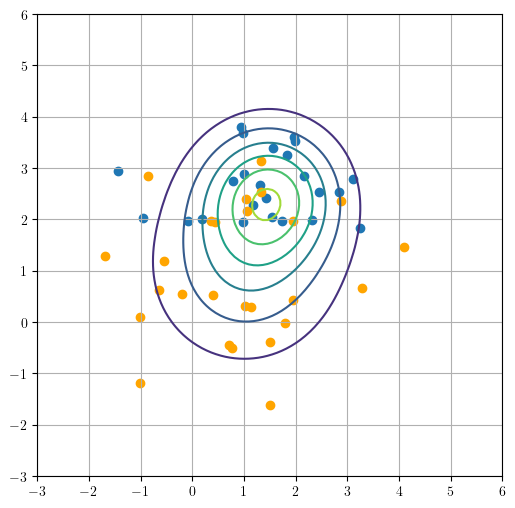

In [120]:
#Defining the model and sampling data points
D = 2

mean_1_cli = torch.tensor([1.5,2.5])
var_1_cli = torch.tensor([[.8, 0],[0,.8]])
mean_2_cli = torch.ones(D)
var_2_cli = torch.tensor([[1.5, 0],[0,1.5]])
w = 0.5

samples_cli = Gaussian.HeterogenousSampleMix([mean_1_cli,mean_2_cli], [var_1_cli,var_2_cli], torch.tensor([1-w,w]), 50)
true_samples_cli = samples_cli[0]
noise_samples_cli = samples_cli[1]
samples_cli_ = torch.cat((true_samples_cli, noise_samples_cli))
samp_cli = samples_cli_.numpy()

rndint = np.random.default_rng(86_960_949)
wait = rndint.integers(8, size=num_clients)
plt.figure(figsize=(6,6))
X = np.linspace(-3,6, 100)
Y = np.linspace(-3,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(mean_1_cli.numpy(), var_1_cli.numpy())
rv2 = multivariate_normal(mean_2_cli.numpy(), var_2_cli.numpy())
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = (1-w) * Z + w * Z2
#plt.contour(X,Y,Z)
#plt.contour(X,Y,Z2, colors=cmap1)
plt.contour(X,Y,trial)
#Z_ = Gaussian.GaussianMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor(A), torch.tensor([.75,.25]))

#plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=1)
plt.scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=1)

plt.grid(visible=True)

In [121]:
samples_1 = homogeneous_split(samples_cli_, 1)
samples_2 = homogeneous_split(samples_cli_, 2)
samples_3 = homogeneous_split(samples_cli_, 3)
samples_4 = homogeneous_split(samples_cli_, 4)
samples_5 = homogeneous_split(samples_cli_, 5)
samples_6 = homogeneous_split(samples_cli_, 6)
samples_8 = homogeneous_split(samples_cli_, 8)
samples_10 = homogeneous_split(samples_cli_, 10)
samples_12 = homogeneous_split(samples_cli_, 12)
samples_15 = homogeneous_split(samples_cli_, 15)
samples_17 = homogeneous_split(samples_cli_, 17)
samples_20 = homogeneous_split(samples_cli_, 20)
samples_25 = homogeneous_split(samples_cli_, 25)
samples_50 = homogeneous_split(samples_cli_, 50)

samples_list = [samples_1, samples_2, samples_3, samples_4, samples_5, samples_6, samples_8, samples_10,
                samples_12, samples_15, samples_17, samples_20, samples_25,samples_50]

In [133]:
parameters_base = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([1.5]),
    "b": torch.tensor([10.]),
    "D": 2,
    "N": 32,
    "Epochs": 75,
    "Divergence": "AR",
    "lr": 5e-4,
    "samples": 50,
    "optim_epochs": 50,
    "batch_size": 25,
    "alpha": 0.6,
    "loss": "beta",
    "beta_l": 1.25
}

q_global_base = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([10.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_base = {
        "client_idx": None,
        "x_n": None,
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.8]),
        "noise_m": torch.tensor([1., 1.]),
        "noise_v": parameters_base["a"],
        "spherical": True,
        "require_s_n": False
    }

In [134]:
qs=[]
client_list = []
for samples in samples_list:
    temp = copy.deepcopy(q_global_base)
    qs.append(temp)
    cl = []
    for i in range(len(samples)):
        temp = copy.deepcopy(clients_base)
        temp.update({"client_idx": i, "x_n": samples[i]})
        cl.append(temp)
    client_list.append(cl)

In [135]:
parameters_base.update({"Epochs":15, "optim_epochs": 1500})
#q_new_1, _ = PartitionedVariationalInference(qs[0], client_list[0], parameters_base)
parameters_base.update({"Epochs":100, "optim_epochs": 140})
q_new_2, _ = PartitionedVariationalInference(qs[1], client_list[1], parameters_base)
q_new_3, _ = PartitionedVariationalInference(qs[2], client_list[2], parameters_base)
parameters_base.update({"Epochs":125,"optim_epochs": 75})
q_new_4, _ = PartitionedVariationalInference(qs[3], client_list[3], parameters_base)
parameters_base.update({"optim_epochs": 60})
q_new_5, _ = PartitionedVariationalInference(qs[4], client_list[4], parameters_base)
q_new_6, _ = PartitionedVariationalInference(qs[5], client_list[5], parameters_base)
q_new_8, _ = PartitionedVariationalInference(qs[6], client_list[6], parameters_base)
q_new_10, _ = PartitionedVariationalInference(qs[7], client_list[7], parameters_base)
q_new_12, _ = PartitionedVariationalInference(qs[8], client_list[8], parameters_base)
q_new_15, _ = PartitionedVariationalInference(qs[9], client_list[9], parameters_base)
q_new_17, _ = PartitionedVariationalInference(qs[10], client_list[10], parameters_base)
q_new_20, _ = PartitionedVariationalInference(qs[11], client_list[11], parameters_base)
q_new_25, _ = PartitionedVariationalInference(qs[12], client_list[12], parameters_base)
q_new_50, _ = PartitionedVariationalInference(qs[13], client_list[13], parameters_base)


Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([10.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0905, 0.1219], requires_grad=True) 
 var:  Parameter containing:
tensor([9.8639], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.1878, 0.2351], requires_grad=True) 
 var:  Parameter containing:
tensor([9.7263], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.2803, 0.3503], requires_grad=True) 
 var:  Parameter containing:
tensor([9.5913], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.3538, 0.4628], requires_grad=True) 
 var:  Parameter containing:
tensor([9.4538], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.4328, 0.5658], requires_grad=True) 
 var:  Parameter cont

New global q: 
 loc:  Parameter containing:
tensor([1.2159, 2.0702], requires_grad=True) 
 var:  Parameter containing:
tensor([4.5692], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.2178, 2.0927], requires_grad=True) 
 var:  Parameter containing:
tensor([4.4293], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.2267, 2.0923], requires_grad=True) 
 var:  Parameter containing:
tensor([4.2887], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.2370, 2.1018], requires_grad=True) 
 var:  Parameter containing:
tensor([4.1485], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.2462, 2.1208], requires_grad=True) 
 var:  Parameter containing:
tensor([4.0080], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([1.2500, 2.1333], requires_grad=True) 
 var:  Parameter containing:
tensor([3.8682], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5334, 2.5794], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0938], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.5188, 2.5748], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0993], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.5293, 2.5819], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0943], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.5237, 2.5762], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0972], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.5281, 2.5804], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0912], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([1.5230, 2.5780], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0964], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.1202, 1.8470], requires_grad=True) 
 var:  Parameter containing:
tensor([6.6709], requires_grad=True)
Iteration 17:
New global q: 
 loc:  Parameter containing:
tensor([1.1309, 1.8873], requires_grad=True) 
 var:  Parameter containing:
tensor([6.4637], requires_grad=True)
Iteration 18:
New global q: 
 loc:  Parameter containing:
tensor([1.1387, 1.9069], requires_grad=True) 
 var:  Parameter containing:
tensor([6.2554], requires_grad=True)
Iteration 19:
New global q: 
 loc:  Parameter containing:
tensor([1.1593, 1.9338], requires_grad=True) 
 var:  Parameter containing:
tensor([6.0454], requires_grad=True)
Iteration 20:
New global q: 
 loc:  Parameter containing:
tensor([1.1469, 1.9816], requires_grad=True) 
 var:  Parameter containing:
tensor([5.8361], requires_grad=True)
Iteration 21:
New global q: 
 loc:  Parameter containing:
tensor([1.1508, 1.9953], requires_grad=True) 
 var:  Parameter containing:
tensor([5.6251], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5520, 2.5736], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0705], requires_grad=True)
Iteration 56:
New global q: 
 loc:  Parameter containing:
tensor([1.5592, 2.5741], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0671], requires_grad=True)
Iteration 57:
New global q: 
 loc:  Parameter containing:
tensor([1.5537, 2.5718], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0701], requires_grad=True)
Iteration 58:
New global q: 
 loc:  Parameter containing:
tensor([1.5513, 2.5750], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0691], requires_grad=True)
Iteration 59:
New global q: 
 loc:  Parameter containing:
tensor([1.5544, 2.5696], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0706], requires_grad=True)
Iteration 60:
New global q: 
 loc:  Parameter containing:
tensor([1.5551, 2.5723], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0716], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5554, 2.5703], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0684], requires_grad=True)
Iteration 95:
New global q: 
 loc:  Parameter containing:
tensor([1.5560, 2.5702], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0742], requires_grad=True)
Iteration 96:
New global q: 
 loc:  Parameter containing:
tensor([1.5563, 2.5744], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0696], requires_grad=True)
Iteration 97:
New global q: 
 loc:  Parameter containing:
tensor([1.5584, 2.5763], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0671], requires_grad=True)
Iteration 98:
New global q: 
 loc:  Parameter containing:
tensor([1.5551, 2.5746], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0687], requires_grad=True)
Iteration 99:
New global q: 
 loc:  Parameter containing:
tensor([1.5548, 2.5702], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0682], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.1749, 2.0225], requires_grad=True) 
 var:  Parameter containing:
tensor([5.2529], requires_grad=True)
Iteration 33:
New global q: 
 loc:  Parameter containing:
tensor([1.1777, 2.0260], requires_grad=True) 
 var:  Parameter containing:
tensor([5.1033], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([1.1967, 2.0234], requires_grad=True) 
 var:  Parameter containing:
tensor([4.9543], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([1.1955, 2.0312], requires_grad=True) 
 var:  Parameter containing:
tensor([4.8045], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([1.1939, 2.0400], requires_grad=True) 
 var:  Parameter containing:
tensor([4.6554], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.2044, 2.0462], requires_grad=True) 
 var:  Parameter containing:
tensor([4.5057], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5429, 2.5702], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0800], requires_grad=True)
Iteration 72:
New global q: 
 loc:  Parameter containing:
tensor([1.5492, 2.5700], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0825], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([1.5432, 2.5678], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0823], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([1.5452, 2.5667], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0859], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([1.5444, 2.5713], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0834], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([1.5423, 2.5671], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0828], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5469, 2.5681], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0835], requires_grad=True)
Iteration 111:
New global q: 
 loc:  Parameter containing:
tensor([1.5475, 2.5712], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0812], requires_grad=True)
Iteration 112:
New global q: 
 loc:  Parameter containing:
tensor([1.5451, 2.5704], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0829], requires_grad=True)
Iteration 113:
New global q: 
 loc:  Parameter containing:
tensor([1.5463, 2.5687], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0855], requires_grad=True)
Iteration 114:
New global q: 
 loc:  Parameter containing:
tensor([1.5437, 2.5662], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0806], requires_grad=True)
Iteration 115:
New global q: 
 loc:  Parameter containing:
tensor([1.5421, 2.5680], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0829], requires_

New global q: 
 loc:  Parameter containing:
tensor([1.0777, 1.7382], requires_grad=True) 
 var:  Parameter containing:
tensor([6.6062], requires_grad=True)
Iteration 24:
New global q: 
 loc:  Parameter containing:
tensor([1.0748, 1.7821], requires_grad=True) 
 var:  Parameter containing:
tensor([6.4577], requires_grad=True)
Iteration 25:
New global q: 
 loc:  Parameter containing:
tensor([1.0921, 1.8153], requires_grad=True) 
 var:  Parameter containing:
tensor([6.3089], requires_grad=True)
Iteration 26:
New global q: 
 loc:  Parameter containing:
tensor([1.1031, 1.8408], requires_grad=True) 
 var:  Parameter containing:
tensor([6.1591], requires_grad=True)
Iteration 27:
New global q: 
 loc:  Parameter containing:
tensor([1.1107, 1.8710], requires_grad=True) 
 var:  Parameter containing:
tensor([6.0109], requires_grad=True)
Iteration 28:
New global q: 
 loc:  Parameter containing:
tensor([1.1180, 1.8951], requires_grad=True) 
 var:  Parameter containing:
tensor([5.8613], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5286, 2.5445], requires_grad=True) 
 var:  Parameter containing:
tensor([0.8110], requires_grad=True)
Iteration 63:
New global q: 
 loc:  Parameter containing:
tensor([1.5491, 2.5512], requires_grad=True) 
 var:  Parameter containing:
tensor([0.6703], requires_grad=True)
Iteration 64:
New global q: 
 loc:  Parameter containing:
tensor([1.5726, 2.5603], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5280], requires_grad=True)
Iteration 65:
New global q: 
 loc:  Parameter containing:
tensor([1.5920, 2.5732], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3933], requires_grad=True)
Iteration 66:
New global q: 
 loc:  Parameter containing:
tensor([1.6126, 2.5775], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2578], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([1.6304, 2.5845], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1377], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5725, 2.5621], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0802], requires_grad=True)
Iteration 102:
New global q: 
 loc:  Parameter containing:
tensor([1.5677, 2.5649], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0796], requires_grad=True)
Iteration 103:
New global q: 
 loc:  Parameter containing:
tensor([1.5637, 2.5611], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0789], requires_grad=True)
Iteration 104:
New global q: 
 loc:  Parameter containing:
tensor([1.5632, 2.5590], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0801], requires_grad=True)
Iteration 105:
New global q: 
 loc:  Parameter containing:
tensor([1.5715, 2.5603], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0821], requires_grad=True)
Iteration 106:
New global q: 
 loc:  Parameter containing:
tensor([1.5663, 2.5623], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0764], requires_

New global q: 
 loc:  Parameter containing:
tensor([0.8680, 1.5820], requires_grad=True) 
 var:  Parameter containing:
tensor([7.5350], requires_grad=True)
Iteration 15:
New global q: 
 loc:  Parameter containing:
tensor([0.8701, 1.6382], requires_grad=True) 
 var:  Parameter containing:
tensor([7.3567], requires_grad=True)
Iteration 16:
New global q: 
 loc:  Parameter containing:
tensor([0.9189, 1.6996], requires_grad=True) 
 var:  Parameter containing:
tensor([7.1791], requires_grad=True)
Iteration 17:
New global q: 
 loc:  Parameter containing:
tensor([0.9318, 1.7425], requires_grad=True) 
 var:  Parameter containing:
tensor([7.0021], requires_grad=True)
Iteration 18:
New global q: 
 loc:  Parameter containing:
tensor([0.9568, 1.7617], requires_grad=True) 
 var:  Parameter containing:
tensor([6.8232], requires_grad=True)
Iteration 19:
New global q: 
 loc:  Parameter containing:
tensor([0.9747, 1.8116], requires_grad=True) 
 var:  Parameter containing:
tensor([6.6436], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.3910, 2.4892], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5658], requires_grad=True)
Iteration 54:
New global q: 
 loc:  Parameter containing:
tensor([1.4003, 2.5090], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3884], requires_grad=True)
Iteration 55:
New global q: 
 loc:  Parameter containing:
tensor([1.4077, 2.5415], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2204], requires_grad=True)
Iteration 56:
New global q: 
 loc:  Parameter containing:
tensor([1.4187, 2.5515], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1037], requires_grad=True)
Iteration 57:
New global q: 
 loc:  Parameter containing:
tensor([1.4479, 2.5370], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0684], requires_grad=True)
Iteration 58:
New global q: 
 loc:  Parameter containing:
tensor([1.4904, 2.5500], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0693], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5571, 2.5685], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0788], requires_grad=True)
Iteration 93:
New global q: 
 loc:  Parameter containing:
tensor([1.5590, 2.5662], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0765], requires_grad=True)
Iteration 94:
New global q: 
 loc:  Parameter containing:
tensor([1.5552, 2.5707], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0748], requires_grad=True)
Iteration 95:
New global q: 
 loc:  Parameter containing:
tensor([1.5576, 2.5707], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0738], requires_grad=True)
Iteration 96:
New global q: 
 loc:  Parameter containing:
tensor([1.5570, 2.5704], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0797], requires_grad=True)
Iteration 97:
New global q: 
 loc:  Parameter containing:
tensor([1.5552, 2.5671], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0794], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([0.4956, 0.6661], requires_grad=True) 
 var:  Parameter containing:
tensor([8.8447], requires_grad=True)
Iteration 6:
New global q: 
 loc:  Parameter containing:
tensor([0.5830, 0.7740], requires_grad=True) 
 var:  Parameter containing:
tensor([8.6090], requires_grad=True)
Iteration 7:
New global q: 
 loc:  Parameter containing:
tensor([0.6662, 0.8779], requires_grad=True) 
 var:  Parameter containing:
tensor([8.3736], requires_grad=True)
Iteration 8:
New global q: 
 loc:  Parameter containing:
tensor([0.7391, 0.9698], requires_grad=True) 
 var:  Parameter containing:
tensor([8.1362], requires_grad=True)
Iteration 9:
New global q: 
 loc:  Parameter containing:
tensor([0.8111, 1.0738], requires_grad=True) 
 var:  Parameter containing:
tensor([7.9007], requires_grad=True)
Iteration 10:
New global q: 
 loc:  Parameter containing:
tensor([0.8596, 1.1393], requires_grad=True) 
 var:  Parameter containing:
tensor([7.6631], requires_grad=True

New global q: 
 loc:  Parameter containing:
tensor([1.4432, 2.4764], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0703], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([1.4684, 2.5131], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0780], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parameter containing:
tensor([1.4935, 2.5298], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0816], requires_grad=True)
Iteration 47:
New global q: 
 loc:  Parameter containing:
tensor([1.5212, 2.5477], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0837], requires_grad=True)
Iteration 48:
New global q: 
 loc:  Parameter containing:
tensor([1.5409, 2.5587], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0881], requires_grad=True)
Iteration 49:
New global q: 
 loc:  Parameter containing:
tensor([1.5524, 2.5630], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0886], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5590, 2.5573], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0878], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([1.5612, 2.5632], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0918], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([1.5570, 2.5596], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0863], requires_grad=True)
Iteration 86:
New global q: 
 loc:  Parameter containing:
tensor([1.5557, 2.5668], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0952], requires_grad=True)
Iteration 87:
New global q: 
 loc:  Parameter containing:
tensor([1.5570, 2.5628], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0875], requires_grad=True)
Iteration 88:
New global q: 
 loc:  Parameter containing:
tensor([1.5554, 2.5573], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0861], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5592, 2.5657], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0967], requires_grad=True)
Iteration 123:
New global q: 
 loc:  Parameter containing:
tensor([1.5569, 2.5639], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0863], requires_grad=True)
Iteration 124:
New global q: 
 loc:  Parameter containing:
tensor([1.5562, 2.5561], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0859], requires_grad=True)
Iteration 125:
New global q: 
 loc:  Parameter containing:
tensor([1.5584, 2.5644], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0912], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([10.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.1433, 0.1909], requires_grad=True) 
 var:  Parameter containing:

New global q: 
 loc:  Parameter containing:
tensor([1.4431, 2.5557], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1079], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([1.4633, 2.5686], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0664], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.4810, 2.5695], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0679], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([1.4819, 2.5754], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0755], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.4888, 2.5741], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0760], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.5175, 2.5814], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0763], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5453, 2.5764], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0769], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([1.5560, 2.5779], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0839], requires_grad=True)
Iteration 76:
New global q: 
 loc:  Parameter containing:
tensor([1.5508, 2.5783], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0820], requires_grad=True)
Iteration 77:
New global q: 
 loc:  Parameter containing:
tensor([1.5474, 2.5833], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0813], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.5470, 2.5701], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0857], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.5515, 2.5790], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0817], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5511, 2.5792], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0832], requires_grad=True)
Iteration 114:
New global q: 
 loc:  Parameter containing:
tensor([1.5452, 2.5748], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0831], requires_grad=True)
Iteration 115:
New global q: 
 loc:  Parameter containing:
tensor([1.5556, 2.5823], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0803], requires_grad=True)
Iteration 116:
New global q: 
 loc:  Parameter containing:
tensor([1.5505, 2.5810], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0795], requires_grad=True)
Iteration 117:
New global q: 
 loc:  Parameter containing:
tensor([1.5504, 2.5703], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0843], requires_grad=True)
Iteration 118:
New global q: 
 loc:  Parameter containing:
tensor([1.5525, 2.5798], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0745], requires_

New global q: 
 loc:  Parameter containing:
tensor([1.1827, 2.0932], requires_grad=True) 
 var:  Parameter containing:
tensor([0.8545], requires_grad=True)
Iteration 27:
New global q: 
 loc:  Parameter containing:
tensor([1.2148, 2.1497], requires_grad=True) 
 var:  Parameter containing:
tensor([0.5379], requires_grad=True)
Iteration 28:
New global q: 
 loc:  Parameter containing:
tensor([1.2452, 2.2294], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2812], requires_grad=True)
Iteration 29:
New global q: 
 loc:  Parameter containing:
tensor([1.2899, 2.3211], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0986], requires_grad=True)
Iteration 30:
New global q: 
 loc:  Parameter containing:
tensor([1.3556, 2.3909], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0664], requires_grad=True)
Iteration 31:
New global q: 
 loc:  Parameter containing:
tensor([1.4311, 2.4526], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0708], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5502, 2.5657], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0916], requires_grad=True)
Iteration 66:
New global q: 
 loc:  Parameter containing:
tensor([1.5514, 2.5608], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0891], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([1.5480, 2.5648], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0887], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([1.5499, 2.5596], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0907], requires_grad=True)
Iteration 69:
New global q: 
 loc:  Parameter containing:
tensor([1.5511, 2.5703], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0932], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([1.5509, 2.5703], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0917], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5436, 2.5696], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0954], requires_grad=True)
Iteration 105:
New global q: 
 loc:  Parameter containing:
tensor([1.5423, 2.5648], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0862], requires_grad=True)
Iteration 106:
New global q: 
 loc:  Parameter containing:
tensor([1.5474, 2.5680], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0813], requires_grad=True)
Iteration 107:
New global q: 
 loc:  Parameter containing:
tensor([1.5493, 2.5695], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0873], requires_grad=True)
Iteration 108:
New global q: 
 loc:  Parameter containing:
tensor([1.5510, 2.5660], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0885], requires_grad=True)
Iteration 109:
New global q: 
 loc:  Parameter containing:
tensor([1.5486, 2.5633], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0918], requires_

New global q: 
 loc:  Parameter containing:
tensor([1.2692, 2.1388], requires_grad=True) 
 var:  Parameter containing:
tensor([2.5468], requires_grad=True)
Iteration 18:
New global q: 
 loc:  Parameter containing:
tensor([1.3038, 2.1672], requires_grad=True) 
 var:  Parameter containing:
tensor([2.1017], requires_grad=True)
Iteration 19:
New global q: 
 loc:  Parameter containing:
tensor([1.3388, 2.2073], requires_grad=True) 
 var:  Parameter containing:
tensor([1.6624], requires_grad=True)
Iteration 20:
New global q: 
 loc:  Parameter containing:
tensor([1.3813, 2.2510], requires_grad=True) 
 var:  Parameter containing:
tensor([1.2219], requires_grad=True)
Iteration 21:
New global q: 
 loc:  Parameter containing:
tensor([1.4227, 2.3110], requires_grad=True) 
 var:  Parameter containing:
tensor([0.7966], requires_grad=True)
Iteration 22:
New global q: 
 loc:  Parameter containing:
tensor([1.4576, 2.3746], requires_grad=True) 
 var:  Parameter containing:
tensor([0.4115], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5407, 2.5696], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0796], requires_grad=True)
Iteration 57:
New global q: 
 loc:  Parameter containing:
tensor([1.5382, 2.5797], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0828], requires_grad=True)
Iteration 58:
New global q: 
 loc:  Parameter containing:
tensor([1.5449, 2.5749], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0852], requires_grad=True)
Iteration 59:
New global q: 
 loc:  Parameter containing:
tensor([1.5453, 2.5684], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0817], requires_grad=True)
Iteration 60:
New global q: 
 loc:  Parameter containing:
tensor([1.5482, 2.5801], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0812], requires_grad=True)
Iteration 61:
New global q: 
 loc:  Parameter containing:
tensor([1.5423, 2.5717], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0851], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5520, 2.5743], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0795], requires_grad=True)
Iteration 96:
New global q: 
 loc:  Parameter containing:
tensor([1.5441, 2.5702], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0811], requires_grad=True)
Iteration 97:
New global q: 
 loc:  Parameter containing:
tensor([1.5493, 2.5705], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0821], requires_grad=True)
Iteration 98:
New global q: 
 loc:  Parameter containing:
tensor([1.5486, 2.5736], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0790], requires_grad=True)
Iteration 99:
New global q: 
 loc:  Parameter containing:
tensor([1.5470, 2.5756], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0768], requires_grad=True)
Iteration 100:
New global q: 
 loc:  Parameter containing:
tensor([1.5534, 2.5752], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0822], requires_grad

New global q: 
 loc:  Parameter containing:
tensor([0.8843, 1.7232], requires_grad=True) 
 var:  Parameter containing:
tensor([6.0598], requires_grad=True)
Iteration 9:
New global q: 
 loc:  Parameter containing:
tensor([0.9115, 1.8132], requires_grad=True) 
 var:  Parameter containing:
tensor([5.5594], requires_grad=True)
Iteration 10:
New global q: 
 loc:  Parameter containing:
tensor([0.9711, 1.8995], requires_grad=True) 
 var:  Parameter containing:
tensor([5.0598], requires_grad=True)
Iteration 11:
New global q: 
 loc:  Parameter containing:
tensor([1.0286, 1.9284], requires_grad=True) 
 var:  Parameter containing:
tensor([4.5608], requires_grad=True)
Iteration 12:
New global q: 
 loc:  Parameter containing:
tensor([1.0594, 1.9728], requires_grad=True) 
 var:  Parameter containing:
tensor([4.0666], requires_grad=True)
Iteration 13:
New global q: 
 loc:  Parameter containing:
tensor([1.0789, 2.0294], requires_grad=True) 
 var:  Parameter containing:
tensor([3.5729], requires_grad=T

New global q: 
 loc:  Parameter containing:
tensor([1.5389, 2.5746], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0875], requires_grad=True)
Iteration 48:
New global q: 
 loc:  Parameter containing:
tensor([1.5356, 2.5677], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0931], requires_grad=True)
Iteration 49:
New global q: 
 loc:  Parameter containing:
tensor([1.5349, 2.5700], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0943], requires_grad=True)
Iteration 50:
New global q: 
 loc:  Parameter containing:
tensor([1.5361, 2.5712], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0942], requires_grad=True)
Iteration 51:
New global q: 
 loc:  Parameter containing:
tensor([1.5373, 2.5679], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0912], requires_grad=True)
Iteration 52:
New global q: 
 loc:  Parameter containing:
tensor([1.5406, 2.5674], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0929], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5388, 2.5668], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0889], requires_grad=True)
Iteration 87:
New global q: 
 loc:  Parameter containing:
tensor([1.5362, 2.5752], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0901], requires_grad=True)
Iteration 88:
New global q: 
 loc:  Parameter containing:
tensor([1.5394, 2.5631], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0917], requires_grad=True)
Iteration 89:
New global q: 
 loc:  Parameter containing:
tensor([1.5391, 2.5722], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0884], requires_grad=True)
Iteration 90:
New global q: 
 loc:  Parameter containing:
tensor([1.5372, 2.5665], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0922], requires_grad=True)
Iteration 91:
New global q: 
 loc:  Parameter containing:
tensor([1.5317, 2.5656], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0890], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5437, 2.5732], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0907], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([10.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.1991, 0.3478], requires_grad=True) 
 var:  Parameter containing:
tensor([9.4439], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.3764, 0.6614], requires_grad=True) 
 var:  Parameter containing:
tensor([8.8803], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.5340, 0.9167], requires_grad=True) 
 var:  Parameter containing:
tensor([8.3047], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.6642, 1.1400], requires_grad=True) 
 var:  Parameter containing:
tenso

New global q: 
 loc:  Parameter containing:
tensor([1.5415, 2.5770], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0864], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.5339, 2.5783], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0846], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.5444, 2.5735], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0829], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.5465, 2.5708], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0836], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.5417, 2.5716], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0846], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.5390, 2.5770], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0821], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5347, 2.5741], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0834], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.5428, 2.5701], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0867], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.5336, 2.5736], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0817], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.5446, 2.5719], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0885], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.5435, 2.5745], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0812], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.5389, 2.5759], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0850], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5417, 2.5750], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0818], requires_grad=True)
Iteration 117:
New global q: 
 loc:  Parameter containing:
tensor([1.5507, 2.5723], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0842], requires_grad=True)
Iteration 118:
New global q: 
 loc:  Parameter containing:
tensor([1.5377, 2.5744], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0815], requires_grad=True)
Iteration 119:
New global q: 
 loc:  Parameter containing:
tensor([1.5487, 2.5701], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0826], requires_grad=True)
Iteration 120:
New global q: 
 loc:  Parameter containing:
tensor([1.5331, 2.5818], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0824], requires_grad=True)
Iteration 121:
New global q: 
 loc:  Parameter containing:
tensor([1.5411, 2.5761], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0797], requires_

New global q: 
 loc:  Parameter containing:
tensor([1.5428, 2.5712], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0900], requires_grad=True)
Iteration 30:
New global q: 
 loc:  Parameter containing:
tensor([1.5556, 2.5648], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0861], requires_grad=True)
Iteration 31:
New global q: 
 loc:  Parameter containing:
tensor([1.5494, 2.5675], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0878], requires_grad=True)
Iteration 32:
New global q: 
 loc:  Parameter containing:
tensor([1.5419, 2.5720], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0930], requires_grad=True)
Iteration 33:
New global q: 
 loc:  Parameter containing:
tensor([1.5342, 2.5664], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0959], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([1.5560, 2.5625], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0952], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5478, 2.5750], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0876], requires_grad=True)
Iteration 69:
New global q: 
 loc:  Parameter containing:
tensor([1.5416, 2.5734], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0874], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([1.5561, 2.5670], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0921], requires_grad=True)
Iteration 71:
New global q: 
 loc:  Parameter containing:
tensor([1.5414, 2.5655], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0929], requires_grad=True)
Iteration 72:
New global q: 
 loc:  Parameter containing:
tensor([1.5488, 2.5703], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0945], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([1.5470, 2.5708], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0899], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5515, 2.5687], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0901], requires_grad=True)
Iteration 108:
New global q: 
 loc:  Parameter containing:
tensor([1.5250, 2.5713], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0938], requires_grad=True)
Iteration 109:
New global q: 
 loc:  Parameter containing:
tensor([1.5525, 2.5692], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0932], requires_grad=True)
Iteration 110:
New global q: 
 loc:  Parameter containing:
tensor([1.5373, 2.5646], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0970], requires_grad=True)
Iteration 111:
New global q: 
 loc:  Parameter containing:
tensor([1.5514, 2.5696], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0932], requires_grad=True)
Iteration 112:
New global q: 
 loc:  Parameter containing:
tensor([1.5486, 2.5650], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0905], requires_

New global q: 
 loc:  Parameter containing:
tensor([1.5504, 2.5676], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0843], requires_grad=True)
Iteration 21:
New global q: 
 loc:  Parameter containing:
tensor([1.5429, 2.5606], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0854], requires_grad=True)
Iteration 22:
New global q: 
 loc:  Parameter containing:
tensor([1.5394, 2.5702], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0802], requires_grad=True)
Iteration 23:
New global q: 
 loc:  Parameter containing:
tensor([1.5452, 2.5693], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0791], requires_grad=True)
Iteration 24:
New global q: 
 loc:  Parameter containing:
tensor([1.5434, 2.5608], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0839], requires_grad=True)
Iteration 25:
New global q: 
 loc:  Parameter containing:
tensor([1.5513, 2.5690], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0817], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5560, 2.5676], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0786], requires_grad=True)
Iteration 60:
New global q: 
 loc:  Parameter containing:
tensor([1.5546, 2.5696], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0791], requires_grad=True)
Iteration 61:
New global q: 
 loc:  Parameter containing:
tensor([1.5413, 2.5741], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0776], requires_grad=True)
Iteration 62:
New global q: 
 loc:  Parameter containing:
tensor([1.5410, 2.5709], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0799], requires_grad=True)
Iteration 63:
New global q: 
 loc:  Parameter containing:
tensor([1.5443, 2.5752], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0735], requires_grad=True)
Iteration 64:
New global q: 
 loc:  Parameter containing:
tensor([1.5405, 2.5647], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0825], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5423, 2.5682], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0877], requires_grad=True)
Iteration 99:
New global q: 
 loc:  Parameter containing:
tensor([1.5566, 2.5673], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0735], requires_grad=True)
Iteration 100:
New global q: 
 loc:  Parameter containing:
tensor([1.5414, 2.5707], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0820], requires_grad=True)
Iteration 101:
New global q: 
 loc:  Parameter containing:
tensor([1.5427, 2.5709], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0877], requires_grad=True)
Iteration 102:
New global q: 
 loc:  Parameter containing:
tensor([1.5515, 2.5651], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0831], requires_grad=True)
Iteration 103:
New global q: 
 loc:  Parameter containing:
tensor([1.5460, 2.5685], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0855], requires_g

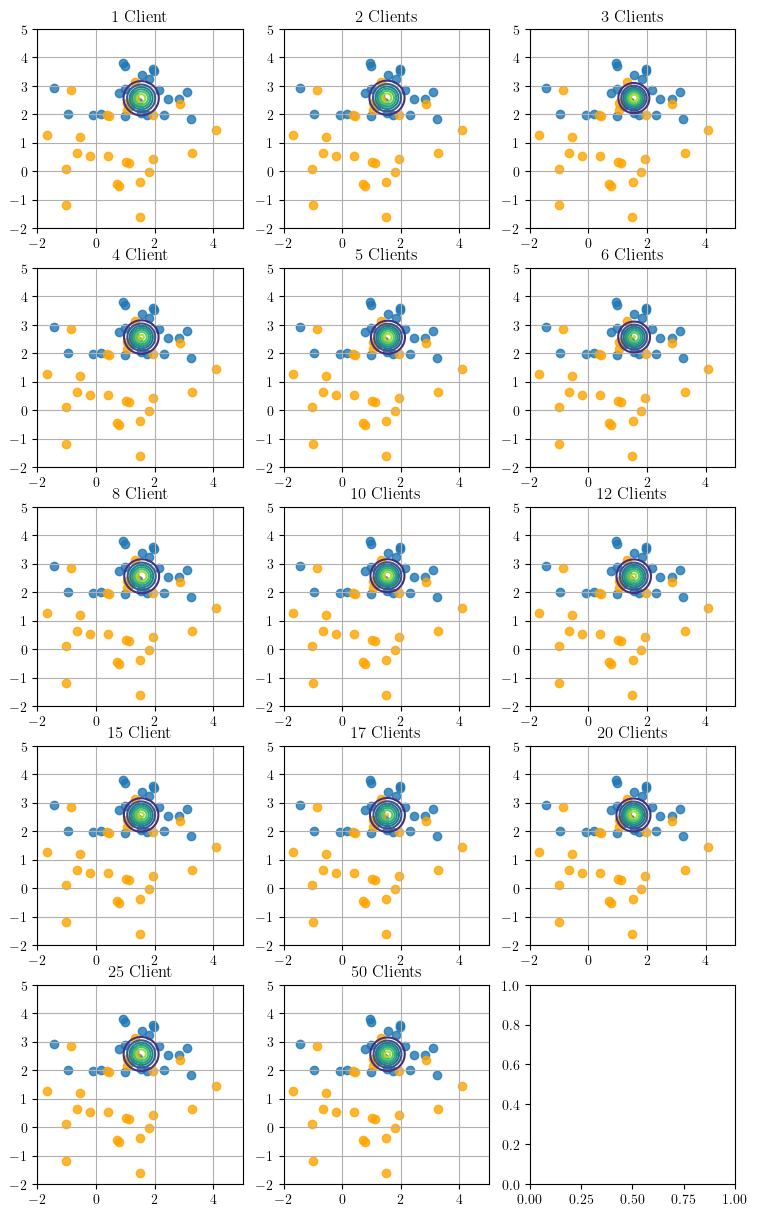

In [136]:
X = np.linspace(-2,5, 1000)
Y = np.linspace(-2,5,1000)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))

rv = multivariate_normal(q_new_1["loc"].detach().numpy(), q_new_1["var"].detach().numpy()*np.eye(2))
Z1 = rv.pdf(pos)
rv = multivariate_normal(q_new_2["loc"].detach().numpy(), q_new_2["var"].detach().numpy()*np.eye(2))
Z2 = rv.pdf(pos)
rv = multivariate_normal(q_new_3["loc"].detach().numpy(), q_new_3["var"].detach().numpy()*np.eye(2))
Z3 = rv.pdf(pos)
rv = multivariate_normal(q_new_4["loc"].detach().numpy(), q_new_4["var"].detach().numpy()*np.eye(2))
Z4 = rv.pdf(pos)
rv = multivariate_normal(q_new_5["loc"].detach().numpy(), q_new_5["var"].detach().numpy()*np.eye(2))
Z5 = rv.pdf(pos)
rv = multivariate_normal(q_new_6["loc"].detach().numpy(), q_new_6["var"].detach().numpy()*np.eye(2))
Z6 = rv.pdf(pos)
rv = multivariate_normal(q_new_8["loc"].detach().numpy(), q_new_8["var"].detach().numpy()*np.eye(2))
Z8 = rv.pdf(pos)
rv = multivariate_normal(q_new_10["loc"].detach().numpy(), q_new_10["var"].detach().numpy()*np.eye(2))
Z10 = rv.pdf(pos)
rv = multivariate_normal(q_new_12["loc"].detach().numpy(), q_new_12["var"].detach().numpy()*np.eye(2))
Z12 = rv.pdf(pos)
rv = multivariate_normal(q_new_15["loc"].detach().numpy(), q_new_15["var"].detach().numpy()*np.eye(2))
Z15 = rv.pdf(pos)
rv = multivariate_normal(q_new_17["loc"].detach().numpy(), q_new_17["var"].detach().numpy()*np.eye(2))
Z17 = rv.pdf(pos)
rv = multivariate_normal(q_new_20["loc"].detach().numpy(), q_new_20["var"].detach().numpy()*np.eye(2))
Z20 = rv.pdf(pos)
rv = multivariate_normal(q_new_25["loc"].detach().numpy(), q_new_25["var"].detach().numpy()*np.eye(2))
Z25 = rv.pdf(pos)
rv = multivariate_normal(q_new_50["loc"].detach().numpy(), q_new_50["var"].detach().numpy()*np.eye(2))
Z50 = rv.pdf(pos)


fig, axs = plt.subplots(5,3, figsize=(9,15))
    
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title(r"1 Client")
axs[0,0].contour(X,Y,Z1)
axs[0,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[0,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[0,0].grid(visible=True)

axs[0,1].set_title(r"2 Clients")
axs[0,1].contour(X,Y,Z2)
axs[0,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[0,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[0,1].grid(visible=True)

axs[0,2].set_title(r"3 Clients")
axs[0,2].contour(X,Y,Z3)
axs[0,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[0,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[0,2].grid(visible=True)

axs[1,0].set_title(r"4 Client")
axs[1,0].contour(X,Y,Z4)
axs[1,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[1,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[1,0].grid(visible=True)

axs[1,1].set_title(r"5 Clients")
axs[1,1].contour(X,Y,Z5)
axs[1,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[1,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[1,1].grid(visible=True)

axs[1,2].set_title(r"6 Clients")
axs[1,2].contour(X,Y,Z6)
axs[1,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[1,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[1,2].grid(visible=True)

axs[2,0].set_title(r"8 Client")
axs[2,0].contour(X,Y,Z8)
axs[2,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[2,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[2,0].grid(visible=True)

axs[2,1].set_title(r"10 Clients")
axs[2,1].contour(X,Y,Z10)
axs[2,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[2,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[2,1].grid(visible=True)

axs[2,2].set_title(r"12 Clients")
axs[2,2].contour(X,Y,Z12)
axs[2,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[2,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[2,2].grid(visible=True)

axs[3,0].set_title(r"15 Client")
axs[3,0].contour(X,Y,Z15)
axs[3,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[3,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[3,0].grid(visible=True)

axs[3,1].set_title(r"17 Clients")
axs[3,1].contour(X,Y,Z17)
axs[3,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[3,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[3,1].grid(visible=True)

axs[3,2].set_title(r"20 Clients")
axs[3,2].contour(X,Y,Z20)
axs[3,2].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[3,2].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[3,2].grid(visible=True)

axs[4,0].set_title(r"25 Client")
axs[4,0].contour(X,Y,Z25)
axs[4,0].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[4,0].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[4,0].grid(visible=True)

axs[4,1].set_title(r"50 Clients")
axs[4,1].contour(X,Y,Z50)
axs[4,1].scatter(true_samples_cli[:,0], true_samples_cli[:,1], alpha=.8)
axs[4,1].scatter(noise_samples_cli[:,0], noise_samples_cli[:,1],c="orange", alpha=.8)
axs[4,1].grid(visible=True)
    
plt.show()

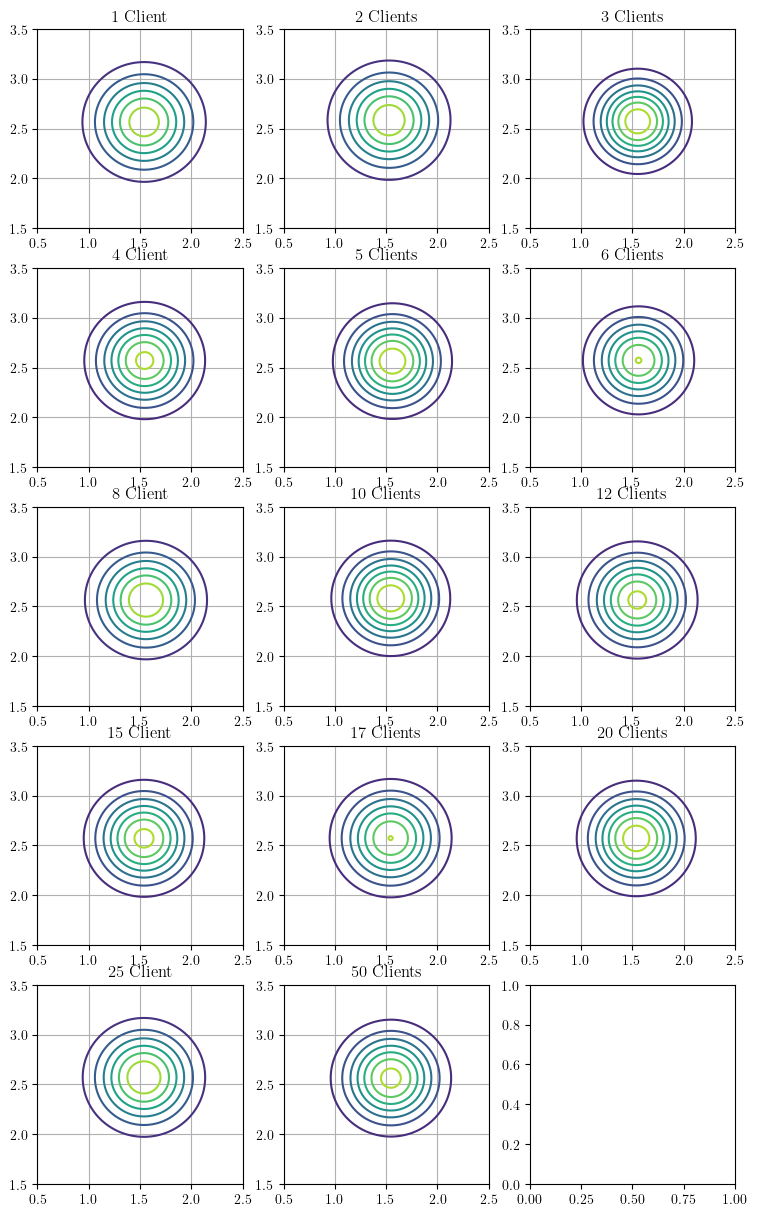

In [137]:
X = np.linspace(.5,2.5, 1000)
Y = np.linspace(1.5,3.5,1000)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))

rv = multivariate_normal(q_new_1["loc"].detach().numpy(), q_new_1["var"].detach().numpy()*np.eye(2))
Z1 = rv.pdf(pos)
rv = multivariate_normal(q_new_2["loc"].detach().numpy(), q_new_2["var"].detach().numpy()*np.eye(2))
Z2 = rv.pdf(pos)
rv = multivariate_normal(q_new_3["loc"].detach().numpy(), q_new_3["var"].detach().numpy()*np.eye(2))
Z3 = rv.pdf(pos)
rv = multivariate_normal(q_new_4["loc"].detach().numpy(), q_new_4["var"].detach().numpy()*np.eye(2))
Z4 = rv.pdf(pos)
rv = multivariate_normal(q_new_5["loc"].detach().numpy(), q_new_5["var"].detach().numpy()*np.eye(2))
Z5 = rv.pdf(pos)
rv = multivariate_normal(q_new_6["loc"].detach().numpy(), q_new_6["var"].detach().numpy()*np.eye(2))
Z6 = rv.pdf(pos)
rv = multivariate_normal(q_new_8["loc"].detach().numpy(), q_new_8["var"].detach().numpy()*np.eye(2))
Z8 = rv.pdf(pos)
rv = multivariate_normal(q_new_10["loc"].detach().numpy(), q_new_10["var"].detach().numpy()*np.eye(2))
Z10 = rv.pdf(pos)
rv = multivariate_normal(q_new_12["loc"].detach().numpy(), q_new_12["var"].detach().numpy()*np.eye(2))
Z12 = rv.pdf(pos)
rv = multivariate_normal(q_new_15["loc"].detach().numpy(), q_new_15["var"].detach().numpy()*np.eye(2))
Z15 = rv.pdf(pos)
rv = multivariate_normal(q_new_17["loc"].detach().numpy(), q_new_17["var"].detach().numpy()*np.eye(2))
Z17 = rv.pdf(pos)
rv = multivariate_normal(q_new_20["loc"].detach().numpy(), q_new_20["var"].detach().numpy()*np.eye(2))
Z20 = rv.pdf(pos)
rv = multivariate_normal(q_new_25["loc"].detach().numpy(), q_new_25["var"].detach().numpy()*np.eye(2))
Z25 = rv.pdf(pos)
rv = multivariate_normal(q_new_50["loc"].detach().numpy(), q_new_50["var"].detach().numpy()*np.eye(2))
Z50 = rv.pdf(pos)


fig, axs = plt.subplots(5,3, figsize=(9,15))
    
#fig.figure(figsize=(6,6), dpi=125)
axs[0,0].set_title(r"1 Client")
axs[0,0].contour(X,Y,Z1)

axs[0,0].grid(visible=True)

axs[0,1].set_title(r"2 Clients")
axs[0,1].contour(X,Y,Z2)

axs[0,1].grid(visible=True)

axs[0,2].set_title(r"3 Clients")
axs[0,2].contour(X,Y,Z3)

axs[0,2].grid(visible=True)

axs[1,0].set_title(r"4 Client")
axs[1,0].contour(X,Y,Z4)

axs[1,0].grid(visible=True)

axs[1,1].set_title(r"5 Clients")
axs[1,1].contour(X,Y,Z5)

axs[1,1].grid(visible=True)

axs[1,2].set_title(r"6 Clients")
axs[1,2].contour(X,Y,Z6)

axs[1,2].grid(visible=True)

axs[2,0].set_title(r"8 Client")
axs[2,0].contour(X,Y,Z8)

axs[2,0].grid(visible=True)

axs[2,1].set_title(r"10 Clients")
axs[2,1].contour(X,Y,Z10)

axs[2,1].grid(visible=True)

axs[2,2].set_title(r"12 Clients")
axs[2,2].contour(X,Y,Z12)

axs[2,2].grid(visible=True)

axs[3,0].set_title(r"15 Client")
axs[3,0].contour(X,Y,Z15)

axs[3,0].grid(visible=True)

axs[3,1].set_title(r"17 Clients")
axs[3,1].contour(X,Y,Z17)


axs[3,1].grid(visible=True)

axs[3,2].set_title(r"20 Clients")
axs[3,2].contour(X,Y,Z20)

axs[3,2].grid(visible=True)

axs[4,0].set_title(r"25 Client")
axs[4,0].contour(X,Y,Z25)

axs[4,0].grid(visible=True)

axs[4,1].set_title(r"50 Clients")
axs[4,1].contour(X,Y,Z50)

axs[4,1].grid(visible=True)
    
plt.show()

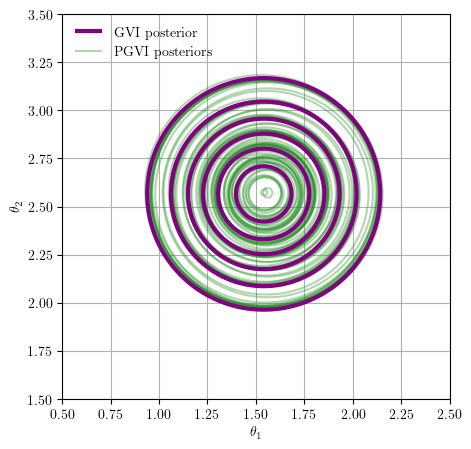

In [171]:
X = np.linspace(.5,2.5, 100)
Y = np.linspace(1.5,3.5,100)
#X = np.linspace(-1,4.5, 100)
#Y = np.linspace(-1,4.5,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(mean_1_cli.numpy(), var_1_cli.numpy())
rv2 = multivariate_normal(mean_2_cli.numpy(), var_2_cli.numpy())
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = (1-w) * Z + w * Z2

plt.figure(figsize=(5,5))
for i in range(1,14):
    rv = multivariate_normal(qs[i]["loc"].detach().numpy(), qs[i]["var"].detach().numpy()*np.eye(2))
    Z = rv.pdf(pos)
    c1 = plt.contour(X,Y,Z, alpha=.35, colors="forestgreen")


#plt.contour(X,Y,trial)
rv2 = multivariate_normal(q_new_1["loc"].detach().numpy(), q_new_1["var"].detach().numpy()*np.eye(2))
Zvi = rv2.pdf(pos)
c2= plt.contour(X,Y,Zvi, colors="purple", alpha=1., linewidths=3)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()

plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

plt.legend([h2[0],h1[0]], [r"GVI posterior", "PGVI posteriors"], loc="upper left", frameon=False)

plt.grid(visible=True)
plt.savefig('num_clients_pgvi.pgf', pad_inches=0)
plt.show()

In [143]:
nums =[1,2,3,4,5,6,8,10,12,15,17,20,25,50]
for i in range(1,14):
    dif = q_new_1["loc"].detach() - qs[i]["loc"].detach()
    norm_mean = torch.linalg.vector_norm(dif)
    mat_dif = q_new_1["var"].detach()*torch.eye(2) - qs[i]["var"].detach()*torch.eye(2)
    norm_cov = torch.linalg.matrix_norm(mat_dif)
    lsgv = torch.abs(torch.linalg.det(q_new_1["var"].detach()*torch.eye(2)).log() - torch.linalg.det(qs[i]["var"].detach()*torch.eye(2)).log())
    print(f"Clients: {nums[i]}, Norm: {norm_mean}, Frobenius Norm: {norm_cov}, Log SGV difference: {lsgv}")

Clients: 2, Norm: 0.02161693455833732, Frobenius Norm: 0.001946614900543552, Log SGV difference: 0.02914579144503371
Clients: 3, Norm: 0.013548001171406613, Frobenius Norm: 0.03823998411879627, Log SGV difference: 0.6687068081087499
Clients: 4, Norm: 0.006781454633442118, Frobenius Norm: 0.011090230784845003, Log SGV difference: 0.17203646515189952
Clients: 5, Norm: 0.021068437483837393, Frobenius Norm: 0.01769021359696634, Log SGV difference: 0.28191439406989094
Clients: 6, Norm: 0.021283834156125527, Frobenius Norm: 0.027899974094542517, Log SGV difference: 0.4647530002299618
Clients: 8, Norm: 0.018090091055288107, Frobenius Norm: 0.005637376064586887, Log SGV difference: 0.08559983589352615
Clients: 10, Norm: 0.016120284455518795, Frobenius Norm: 0.018667096235526877, Log SGV difference: 0.2987030544210416
Clients: 12, Norm: 0.007300534557700177, Frobenius Norm: 0.011413350119545678, Log SGV difference: 0.17727758754258183
Clients: 15, Norm: 0.005543565991853878, Frobenius Norm: 0.0

## Section 3.7.4 Update Schedule

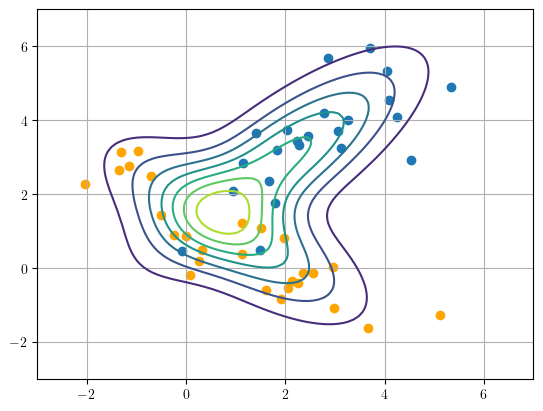

In [182]:
#Defining the model and sampling data points
D = 2

mean_1_gaus = torch.tensor([2.,3.])
var_1_gaus = torch.tensor([[2.5, 2.],[2.,2.7]])
mean_2_gaus = torch.ones(D)
var_2_gaus = torch.tensor([[2.2, -1.5],[-1.5,2.]])
w_mult = 0.45
num_clients = 10

samples_gaus = Gaussian.HeterogenousSampleMix([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor([.55,.45]), 50)
true_samples_gaus = samples_gaus[0]
noise_samples_gaus = samples_gaus[1]
samples_gaus = torch.cat((true_samples_gaus, noise_samples_gaus))
samp_gaus = samples_gaus.numpy()
client_data_gaus = homogeneous_split(samples_gaus,num_clients)

rndint = np.random.default_rng(86_960_949)
wait = rndint.integers(8, size=num_clients)

X = np.linspace(-3,7, 100)
Y = np.linspace(-3,7,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal(mean_1_gaus.numpy(), var_1_gaus.numpy())
rv2 = multivariate_normal(mean_2_gaus.numpy(), var_2_gaus.numpy())
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = 0.55 * Z + 0.45 * Z2
#plt.contour(X,Y,Z)
#plt.contour(X,Y,Z2, colors=cmap1)
plt.contour(X,Y,trial)
#Z_ = Gaussian.GaussianMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor(A), torch.tensor([.75,.25]))

#plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=1)
plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=1)

plt.grid(visible=True)

In [183]:
parameters_gaus = {
    "w": torch.tensor(0.45),
    "a": var_2_gaus,
    "b": torch.tensor([[10.,0.],[0.,10.]]),
    "D": 2,
    "N": 50,
    "Epochs": 100,
    "Divergence": "AR",
    "lr": 2.5e-4,
    "samples": 50,
    "alpha": 0.6,
    "optim_epochs": 50,
    "batch_size": 16
}

q_global_gaus = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([[10.,0.],[0.,10.]])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_gaus = []
for i in range(num_clients):
    clients_gaus.append({
        "client_idx": i,
        "x_n": client_data_gaus[i],
        "mean": torch.tensor([0., 0.]),
        "variance": np.inf * torch.eye(2),
        "variance_inverse": 0*torch.eye(2),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_gaus,
        "noise_m": mean_2_gaus,
        "noise_v": var_2_gaus,
        "spherical": False,
        "require_s_n": False,
        "wait_time": wait[i],
        "q_new": {
            "loc": None,
            "var": None
        },
        "q_old": {
            "loc": None,
            "var": None
        }
    })
#print(clients_gaus)
global_qs = []
list_clients = []
for i in range(3):
    temp_g = copy.deepcopy(q_global_gaus)
    temp_c = copy.deepcopy(clients_gaus)
    global_qs.append(temp_g)
    list_clients.append(temp_c)

print("==============================Sequential PVI==============================")
q_seq, _ = PartitionedVariationalInference(global_qs[0], list_clients[0], parameters_gaus)
print("==============================Synchronous PVI==============================")
q_sync, _ = SynchronousPVI(global_qs[1], list_clients[1], parameters_gaus)
parameters_gaus.update({"optim_epochs": 100,})
print("==============================Asynchronous PVI==============================")
q_async, _ = AsynchronousPVI(global_qs[2], list_clients[2], parameters_gaus)


==============================Sequential PVI==============================
Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0683, 0.1124], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8773, 0.1013],
        [0.1013, 9.8814]], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.1319, 0.2227], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.7552, 0.2029],
        [0.2029, 9.7619]], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.1981, 0.3355], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.6318, 0.3032],
        [0.3032, 9.6417]], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.2612, 0.4493], r

New global q: 
 loc:  Parameter containing:
tensor([1.3389, 2.3948], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.9659, 3.6866],
        [3.6866, 5.9734]], requires_grad=True)
Iteration 34:
New global q: 
 loc:  Parameter containing:
tensor([1.3572, 2.4267], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.8454, 3.7992],
        [3.7992, 5.8515]], requires_grad=True)
Iteration 35:
New global q: 
 loc:  Parameter containing:
tensor([1.3715, 2.4548], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.7271, 3.9098],
        [3.9098, 5.7293]], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([1.3867, 2.4799], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.6076, 4.0174],
        [4.0174, 5.6079]], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([1.4054, 2.5062], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.4934, 4.1224],
        [4.1224, 5.4859]], requ

New global q: 
 loc:  Parameter containing:
tensor([2.4736, 3.3400], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.8528, 4.0124],
        [4.0124, 4.3087]], requires_grad=True)
Iteration 67:
New global q: 
 loc:  Parameter containing:
tensor([2.4900, 3.3504], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.8179, 3.9761],
        [3.9761, 4.2874]], requires_grad=True)
Iteration 68:
New global q: 
 loc:  Parameter containing:
tensor([2.5022, 3.3643], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.7780, 3.9383],
        [3.9383, 4.2622]], requires_grad=True)
Iteration 69:
New global q: 
 loc:  Parameter containing:
tensor([2.5169, 3.3762], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.7337, 3.9037],
        [3.9037, 4.2319]], requires_grad=True)
Iteration 70:
New global q: 
 loc:  Parameter containing:
tensor([2.5275, 3.3842], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.6959, 3.8723],
        [3.8723, 4.2053]], requ

New global q: 
 loc:  Parameter containing:
tensor([2.5871, 3.4026], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.6300, 2.8436],
        [2.8436, 3.2819]], requires_grad=True)
Iteration 100:
New global q: 
 loc:  Parameter containing:
tensor([2.5858, 3.3976], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.5926, 2.8084],
        [2.8084, 3.2453]], requires_grad=True)
==============================Synchronous PVI==============================
Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([0.0673, 0.1110], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.8808, 0.0955],
        [0.0955, 9.8817]], requires_grad=True)
Ite

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.1210, 2.0464], requires_grad=True) 
 var:  Parameter containing:
tensor([[7.2649, 2.4496],
        [2.4496, 7.2828]], requires_grad=True)
Iteration 24:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.1591, 2.0946], requires_grad=True) 
 var:  Parameter containing:
tensor([[7.1478, 2.5613],
        [2.5613, 7.1649]], requires_grad=True)
Iteration 25:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.1879, 2.1281], requires_grad=True) 
 var:  Parameter containing:
tensor([[7.0318, 2.6714],
        [2.6714, 7.0475]], requires_grad=True)
Iteration 26:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter

Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.7231, 2.7525], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.7954, 4.6856],
        [4.6856, 4.7535]], requires_grad=True)
Iteration 48:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.7674, 2.7831], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.7481, 4.6923],
        [4.6923, 4.7147]], requires_grad=True)
Iteration 49:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8005, 2.8232], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.7053, 4.6647],
        [4.6647, 4.6979]], requires_grad=True)
Iteration 50:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([1.8420, 2.8720]

Client 9
New global q: 
 loc:  Parameter containing:
tensor([2.5157, 3.3811], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.8046, 3.9710],
        [3.9710, 4.2903]], requires_grad=True)
Iteration 72:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([2.5307, 3.3919], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.7674, 3.9380],
        [3.9380, 4.2707]], requires_grad=True)
Iteration 73:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([2.5408, 3.3981], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.7280, 3.9062],
        [3.9062, 4.2434]], requires_grad=True)
Iteration 74:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([2.5505, 3.4025], requires_grad=True) 
 var:  Parame

Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([2.6092, 3.4302], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.8884, 3.1005],
        [3.1005, 3.5476]], requires_grad=True)
Iteration 97:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([2.6074, 3.4282], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.8496, 3.0675],
        [3.0675, 3.5099]], requires_grad=True)
Iteration 98:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter containing:
tensor([2.6053, 3.4220], requires_grad=True) 
 var:  Parameter containing:
tensor([[2.8127, 3.0362],
        [3.0362, 3.4742]], requires_grad=True)
Iteration 99:
Client 0
Client 1
Client 2
Client 3
Client 4
Client 5
Client 6
Client 7
Client 8
Client 9
New global q: 
 loc:  Parameter

Client 3 with wait time:  2
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 7 with wait time:  4
Client 8 with wait time:  0
Client 9 with wait time:  4
New global q: 
 loc:  Parameter containing:
tensor([0.6502, 1.4930], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.2249, 1.3560],
        [1.3560, 8.2458]], requires_grad=True)
Iteration 17:
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([0.6469, 1.5302], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.1533, 1.4121],
        [1.4121, 8.1730]], requires_grad=True)
Iteration 18:
Client 0 with wait time:  6
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([0.7011, 1.6127], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.0211, 1.5296],
        [1.5296, 8.0375

Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.0759, 2.3346], requires_grad=True) 
 var:  Parameter containing:
tensor([[6.0138, 3.2472],
        [3.2472, 6.0019]], requires_grad=True)
Iteration 38:
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.0754, 2.3368], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.9252, 3.3173],
        [3.3173, 5.9104]], requires_grad=True)
Iteration 39:
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.0775, 2.3783], requires_grad=True) 
 var:  Parameter containing:
tensor([[5.8410, 3.3805],
        [3.3805, 5.8219]], requires_grad=True)
Iteration 40:
Client 2 with wait time:  4
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 6 with wait

Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.4970, 2.7014], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.4152, 4.1055],
        [4.1055, 4.3178]], requires_grad=True)
Iteration 60:
Client 0 with wait time:  6
Client 2 with wait time:  4
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 7 with wait time:  4
Client 8 with wait time:  0
Client 9 with wait time:  4
New global q: 
 loc:  Parameter containing:
tensor([1.5861, 2.7027], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.3327, 4.1332],
        [4.1332, 4.2303]], requires_grad=True)
Iteration 61:
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([1.5857, 2.7206], requires_grad=True) 
 var:  Parameter containing:
tensor([[4.2974, 4.1165],
        [4.1165, 4.2291]], requires_grad=True)
Iter

Client 8 with wait time:  0
Client 9 with wait time:  4
New global q: 
 loc:  Parameter containing:
tensor([2.0910, 2.9496], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.6618, 3.7465],
        [3.7465, 3.9364]], requires_grad=True)
Iteration 81:
Client 4 with wait time:  1
Client 5 with wait time:  3
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([2.1009, 2.9576], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.6345, 3.7286],
        [3.7286, 3.9281]], requires_grad=True)
Iteration 82:
Client 3 with wait time:  2
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 loc:  Parameter containing:
tensor([2.1182, 2.9675], requires_grad=True) 
 var:  Parameter containing:
tensor([[3.6161, 3.7105],
        [3.7105, 3.9165]], requires_grad=True)
Iteration 83:
Client 4 with wait time:  1
Client 6 with wait time:  1
Client 8 with wait time:  0
New global q: 
 lo

In [184]:
#GVI implementation
parameters_gaus_gvi = {
    "w": torch.tensor(0.45),
    "a": var_2_gaus,
    "b": torch.tensor([[10.,0.],[0.,10.]]),
    "D": 2,
    "N": 50,
    "Epochs": 15,
    "Divergence": "AR",
    "lr": 2.5e-4,
    "samples": 50,
    "alpha": 0.6,
    "optim_epochs": 2000,
    "batch_size": 16
}

q_global_gaus_gvi = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([[10.,0.],[0.,10.]])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_gaus_gvi = []
clients_gaus_gvi.append({
    "client_idx": i,
    "x_n": samples_gaus,
    "mean": torch.tensor([0., 0.]),
    "variance": np.inf * torch.eye(2),
    "variance_inverse": 0*torch.eye(2),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": var_1_gaus,
    "noise_m": mean_2_gaus,
    "noise_v": var_2_gaus,
    "spherical": False,
    "require_s_n": False,
})
q_gaus_gvi, _ = PartitionedVariationalInference(q_global_gaus_gvi, clients_gaus_gvi, parameters_gaus_gvi, minibatch=True)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([[10.,  0.],
        [ 0., 10.]], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.3746, 0.4429], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.5212, 0.4511],
        [0.4511, 9.5194]], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.7251, 0.8755], requires_grad=True) 
 var:  Parameter containing:
tensor([[9.0359, 0.9154],
        [0.9154, 9.0368]], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([1.0310, 1.2931], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.5578, 1.3799],
        [1.3799, 8.5569]], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([1.3100, 1.6930], requires_grad=True) 
 var:  Parameter containing:
tensor([[8.0809, 1.8444],


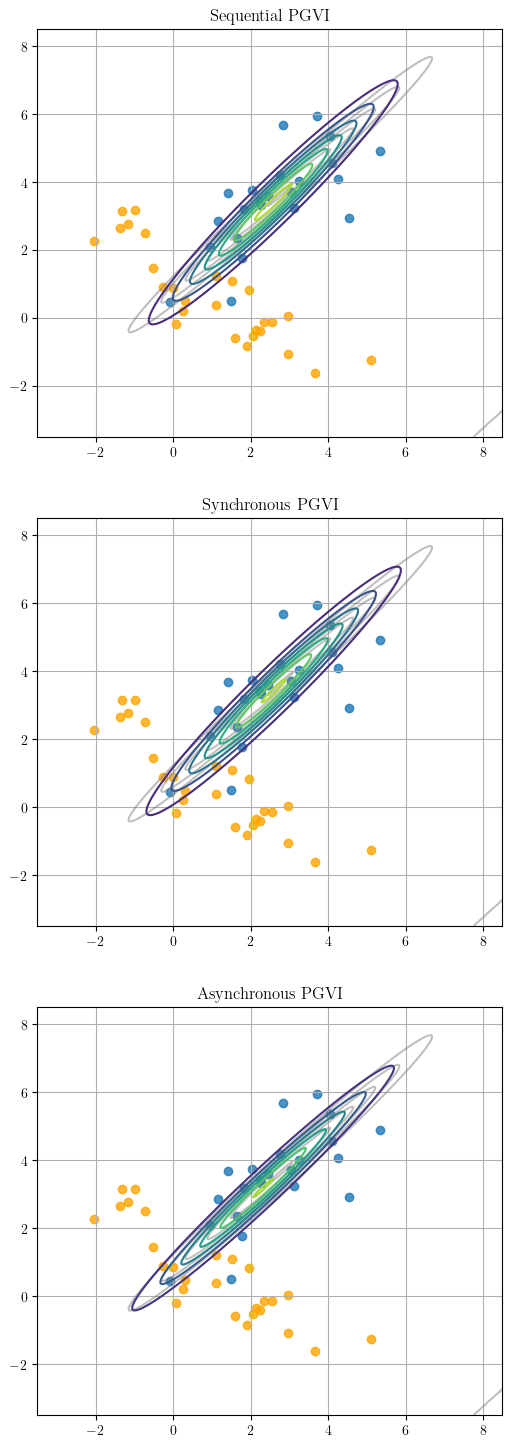

In [185]:
X = np.linspace(-3.5,8.5, 1000)
Y = np.linspace(-3.5,8.5,1000)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))

rv = multivariate_normal(q_seq["loc"].detach().numpy(), q_seq["var"].detach().numpy())
Z = rv.pdf(pos)
rvsync = multivariate_normal(q_sync["loc"].detach().numpy(), q_sync["var"].detach().numpy())
Zsync = rvsync.pdf(pos)
rvasync = multivariate_normal(q_async["loc"].detach().numpy(), q_async["var"].detach().numpy())
Zasync = rvasync.pdf(pos)
rvvi = multivariate_normal(q_gaus_gvi["loc"].detach().numpy(), q_gaus_gvi["var"].detach().numpy())
Z_vi = rvvi.pdf(pos)
#plt.scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=.8)
#plt.grid(visible=True)


fig, axs = plt.subplots(3,1, figsize=(6,18))

for ax in axs:
    rv1 = multivariate_normal(mean_1_gaus.numpy(), var_1_gaus.numpy())
    rv2 = multivariate_normal(mean_2_gaus.numpy(), var_2_gaus.numpy())
    Z1 = rv1.pdf(pos)
    Z2 = rv2.pdf(pos)
    trial = 0.55 * Z1 + 0.45 * Z2
    #plt.contour(X,Y,Z)
    #plt.contour(X,Y,Z2, colors=cmap1)
    #ax.contour(X,Y,trial)
    
    ax.contour(X,Y,Z_vi, colors="grey", alpha=.5)
    
#fig.figure(figsize=(6,6), dpi=125)
axs[0].set_title(r"Sequential PGVI")
axs[0].contour(X,Y,Z)
axs[0].scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=.8)
axs[0].scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=.8)
axs[0].grid(visible=True)

axs[1].set_title(r"Synchronous PGVI")
axs[1].contour(X,Y,Zsync)
axs[1].scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=.8)
axs[1].scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=.8)
axs[1].grid(visible=True)

axs[2].set_title(r"Asynchronous PGVI")
axs[2].contour(X,Y,Zasync)
axs[2].scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], alpha=.8)
axs[2].scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1],c="orange", alpha=.8)
axs[2].grid(visible=True)
    
plt.show()

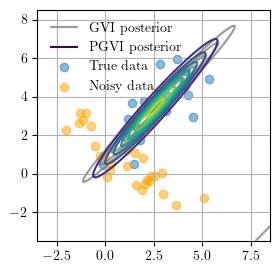

In [187]:
plt.figure(figsize=(3,3))


c2 = plt.contour(X,Y,Z_vi, colors = "grey", alpha=.8)
c3 = plt.contour(X,Y,Z, alpha=1)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)

c4=plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], label="true data", alpha=.5)
c5=plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1], label="noisy data", color='orange', alpha=.5)

h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$\theta_2$")

plt.legend([h2[0], h3[0], c4, c5], [r"GVI posterior", "PGVI posterior", "True data", "Noisy data"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('seq_pgvi.pgf', pad_inches=0)
plt.show()

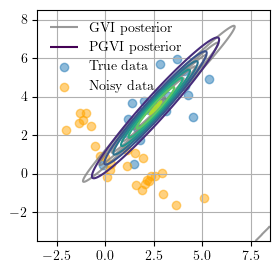

In [188]:
plt.figure(figsize=(3,3))


c2 = plt.contour(X,Y,Z_vi, colors = "grey", alpha=.8)
c3 = plt.contour(X,Y,Zsync, alpha=1)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)

c4=plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], label="true data", alpha=.5)
c5=plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1], label="noisy data", color='orange', alpha=.5)

h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$\theta_2$")

plt.legend([h2[0], h3[0], c4, c5], [r"GVI posterior", "PGVI posterior", "True data", "Noisy data"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('sync_pgvi.pgf', pad_inches=0)
plt.show()

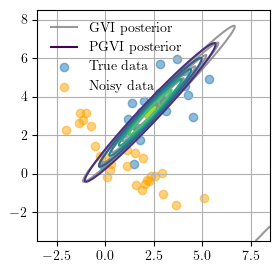

In [189]:
plt.figure(figsize=(3,3))


c2 = plt.contour(X,Y,Z_vi, colors = "grey", alpha=.8)
c3 = plt.contour(X,Y,Zasync, alpha=1)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)

c4=plt.scatter(true_samples_gaus[:,0], true_samples_gaus[:,1], label="true data", alpha=.5)
c5=plt.scatter(noise_samples_gaus[:,0], noise_samples_gaus[:,1], label="noisy data", color='orange', alpha=.5)

h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$\theta_2$")

plt.legend([h2[0], h3[0], c4, c5], [r"GVI posterior", "PGVI posterior", "True data", "Noisy data"], loc="upper left", frameon=False)

#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('async_pgvi.pgf', pad_inches=0)
plt.show()

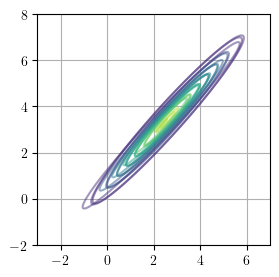

In [201]:


plt.figure(figsize=(3,3))

c1 = plt.contour(X,Y,Z, alpha=.5)
c2 = plt.contour(X,Y,Zsync, alpha=.5)
c3 = plt.contour(X,Y,Zasync, alpha=.5)
#c4 = plt.contour(X_q,Y_q,Z_true, colors = "firebrick", alpha=.5)
#c5 = plt.contour(X_q,Y_q,Z_, colors = "grey", alpha=.5)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$\theta_2$")

#plt.legend([h1[0], h2[0], h3[0]], [r"Sequential posterior", "Synchronous posterior", "Asynchronous posterior"], loc="upper left", frameon=False)
plt.xlim(-3,7)
plt.ylim(-2,8)
#plt.legend([h1[0],h2[0], h3[0], h4[0], h5[0]], [r"EP posterior", r"VI posterior", "PVI posterior", "True Distribution", r"$p(D|\theta)$"], loc="upper left", frameon=False)
plt.grid(visible=True)
#plt.grid(visible=True, alpha=.1)
plt.savefig('updates_comp.pgf', pad_inches=0)
plt.show()

In [190]:
#Sequential Metrics:
#Mean from VI mean, Euclidean Norm
dif = q_gaus_vi["loc"].detach() - q_seq["loc"].detach()
norm_mean = torch.linalg.vector_norm(dif)
mat_dif = q_gaus_vi["var"].detach() - q_seq["var"].detach()
norm_cov = torch.linalg.matrix_norm(mat_dif)
lsgv = torch.abs(torch.linalg.det(q_gaus_vi["var"].detach()).log() - torch.linalg.det(q_seq["var"].detach()).log())
print(f"Norm: {norm_mean}, Frobenius Norm: {norm_cov}, Log SGV difference: {lsgv}")

Norm: 0.8275056330233652, Frobenius Norm: 3.324641908379015, Log SGV difference: 0.02110720353677087


In [193]:
#Synchronous Metrics:
#Mean from VI mean, Euclidean Norm
dif = q_gaus_vi["loc"].detach() - q_sync["loc"].detach()
norm_mean = torch.linalg.vector_norm(dif)
mat_dif = q_gaus_vi["var"].detach() - q_sync["var"].detach()
norm_cov = torch.linalg.matrix_norm(mat_dif)
lsgv = torch.abs(torch.linalg.det(q_gaus_vi["var"].detach()).log() - torch.linalg.det(q_sync["var"].detach()).log())
print(f"Norm: {norm_mean}, Frobenius Norm: {norm_cov}, Log SGV difference: {lsgv}")

Norm: 0.8456623359668802, Frobenius Norm: 3.0149845516781877, Log SGV difference: 0.07268292055809167


In [194]:
#Asynchronous Metrics:
#Mean from VI mean, Euclidean Norm
dif = q_gaus_vi["loc"].detach() - q_async["loc"].detach()
norm_mean = torch.linalg.vector_norm(dif)
mat_dif = q_gaus_vi["var"].detach() - q_async["var"].detach()
norm_cov = torch.linalg.matrix_norm(mat_dif)
lsgv = torch.abs(torch.linalg.det(q_gaus_vi["var"].detach()).log() - torch.linalg.det(q_async["var"].detach()).log())
print(f"Norm: {norm_mean}, Frobenius Norm: {norm_cov}, Log SGV difference: {lsgv}")

Norm: 0.49200361797850967, Frobenius Norm: 2.3455618771489655, Log SGV difference: 0.18103127967602728
